
**Install requirements**

In [0]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
# need tqdm version 4.30.0 for compatibility
!pip3 install 'tqdm==4.30.0'

  Using cached https://files.pythonhosted.org/packages/88/95/90e8c4c31cfc67248bf944ba42029295b77159982f532c5689bcfe4e9108/torch-1.3.1-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.3.1 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Using cached https://files.pythonhosted.org/packages/24/19/4804aea17cd136f1705a5e98a00618cb8f6ccc375ad8bfa437408e09d058/torch-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1


**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torch.autograd import Function
from torch.hub import load_state_dict_from_url

import torchvision
from torchvision import datasets, transforms

from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from google.colab import drive

from statistics import mean, stdev
from collections import defaultdict

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 7 # Number of total classes of PACS dataset
NUM_DOMAINS = 4 # Number of total domains of PACS dataset

BATCH_SIZE = int(256 / 2)     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3         # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = int(20)     # Total number of training epochs (iterations over dataset)
STEP_SIZE = int(20)      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

ALPHA = 0.03

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
# Normalize ImageNet: https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198
mean_imagenet = [0.485, 0.456, 0.406]
std_imagenet = [0.229, 0.224, 0.225]


transform = transforms.Compose([transforms.Resize(256), 
                                transforms.CenterCrop(size=224),  
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_imagenet, std=std_imagenet)])


**Prepare Dataset**

Implemented Dataset

In [0]:
class PACS:

    def __init__(self, root, transform=None):
        self.root = root

        # List of all domains sorted
        self.domains = sorted([d.name for d in os.scandir(self.root) if d.is_dir()])
        self.classes = sorted([d.name for d in os.scandir(os.path.join(self.root, self.domains[0])) if d.is_dir()])
        
        self.datasets = {}
        for domain in self.domains:
            domain_root = os.path.join(self.root, domain)
            self.datasets[domain] = (datasets.ImageFolder(domain_root, transform))

    def get_datasets(self):
        return self.datasets

    def get_classes(self):
        return self.classes

    def get_domains(self):
        return self.domains


In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
    !git clone https://github.com/MachineLearning2020/Homework3-PACS

DATA_DIR = 'Homework3-PACS/PACS'

pacs_datasets = PACS(DATA_DIR, transform)

Cloning into 'Homework3-PACS'...
remote: Enumerating objects: 10032, done.
remote: Total 10032 (delta 0), reused 0 (delta 0), pack-reused 10032
Receiving objects: 100% (10032/10032), 174.13 MiB | 41.07 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (9993/9993), done.


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
photo_dataloader = DataLoader(pacs_datasets.datasets['photo'], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last = True)
art_dataloader = DataLoader(pacs_datasets.datasets['art_painting'], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last = True)
cartoon_dataloader = DataLoader(pacs_datasets.datasets['cartoon'], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
sketch_dataloader = DataLoader(pacs_datasets.datasets['sketch'], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last = True)


In order to check the dataloaders.

Dataset ImageFolder
    Number of datapoints: 2048
    Root location: Homework3-PACS/PACS/art_painting
Dataset ImageFolder
    Number of datapoints: 2344
    Root location: Homework3-PACS/PACS/cartoon
Dataset ImageFolder
    Number of datapoints: 1670
    Root location: Homework3-PACS/PACS/photo
Dataset ImageFolder
    Number of datapoints: 3929
    Root location: Homework3-PACS/PACS/sketch


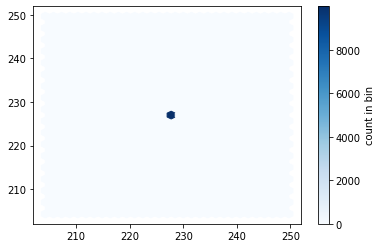

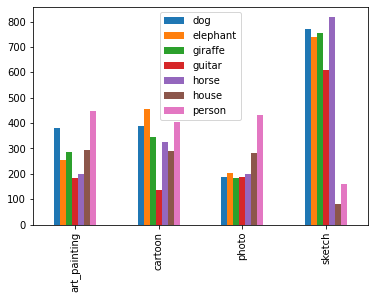

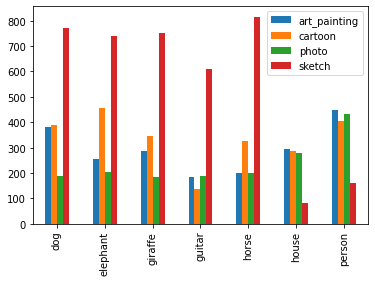

In [0]:
# As our images are normalized we have to denormalize them and 
# convert them to numpy arrays.
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std*img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) #Pause is necessary to display images correctly
    

def image_analysis(dataset):
    class_counter = defaultdict(int)
    size_list = []
    
    for image, label_idx in dataset:
        size_list.append(image.size)
        label = dataset.classes[label_idx]
        class_counter[label] = class_counter[label] + 1
    return size_list, class_counter

#images, labels = next(iter(cartoon_dataloader))
#grid_img = torchvision.utils.make_grid(images[:4], nrow=4)
#imshow(grid_img, title=[cartoon_dataloader.dataset.classes[int(x)] for x in labels[:4]])

pacs_datasets_analysis = PACS(DATA_DIR)

size_list = []
domain_class_counter = {}
for dataset_key, dataset in pacs_datasets_analysis.datasets.items():
    print(str(dataset))
    l, domain_class_counter[dataset_key] = image_analysis(dataset)
    size_list = size_list + l

width = [i[0] for i in size_list]
height = [i[1] for i in size_list]

plt.hexbin(width, height, gridsize=30, cmap='Blues')
cb = plt.colorbar(label='count in bin')

pd.DataFrame(domain_class_counter).T.plot(kind='bar')
plt.show()
pd.DataFrame(domain_class_counter).plot(kind='bar')
plt.show()


**Prepare Network**

In [0]:
# Autograd Function objects are what record operation history on tensors,
# and define formulas for the forward and backprop.

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        # Store context for backprop
        ctx.alpha = alpha
        
        # Forward pass is a no-op
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass is just to -alpha the gradient
        output = grad_output.neg() * ctx.alpha

        # Must return same number as inputs to forward()
        return output, None


In [0]:
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

class AlexNetWithReverseGrad(nn.Module):
    # Implemented DANN on AlexNet
    def __init__(self, num_classes=1000):
        super(AlexNetWithReverseGrad, self).__init__()
        
        # Feature extractor: Convolutional Layers of AlexNet
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        # Label predictor: Fully Connected Layers of AlexNet
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

        # Discriminator
        self.dann_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x, alpha=1.0):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        features = x
        reverse_features = GradientReversalFn.apply(x, alpha)
        
        class_pred = self.classifier(features)
        domain_pred = self.dann_classifier(reverse_features)
        return class_pred, domain_pred

def alexnet_rg(pretrained=False, progress=True, **kwargs):
    """
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNetWithReverseGrad(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'], 
                                              progress=progress)
        model.load_state_dict(state_dict, strict=False)

        model.dann_classifier[1].weight.data = model.classifier[1].weight.data
        model.dann_classifier[1].bias.data = model.classifier[1].bias.data

        model.dann_classifier[4].weight.data = model.classifier[4].weight.data
        model.dann_classifier[4].bias.data = model.classifier[4].bias.data

        model.dann_classifier[6].weight.data = model.classifier[6].weight.data
        model.dann_classifier[6].bias.data = model.classifier[6].bias.data

    return model


**Prepare Model**

In [0]:
def prepare_model(lr, step_size=None, gamma=0.01, num_epochs=None, dann_scheduler=False):
    net = alexnet_rg(pretrained=True) # Loading AlexNet with reversed gradient model pretrained with ImageNet

    net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
    net.dann_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

    # Define loss function
    criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

    # Choose parameters to optimize
    parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

    # Define optimizer
    optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

    # Define scheduler
    if dann_scheduler and num_epochs != None:
        # This is the implementation of the DANN paper scheduler
        dann_scheduler_function = lambda epoch: 1 / pow(1 + 10 * float(epoch) / float(num_epochs), 0.75)
        scheduler = optim.lr_scheduler.LambdaLR(optimizer, dann_scheduler_function)
    elif step_size != None:
        #This is the normal scheduler, this one was used always
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    else:
        raise Exception("Invalid arguments for model preparation")
  
    return net, criterion, optimizer, scheduler

**Load logging**

In [10]:

LOG_DIR = "runs_h3"

# In order to save the results in google drive.
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Colab Notebooks/runs_h3" "/content/runs_h3"

%load_ext tensorboard


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
%tensorboard --logdir runs_h3/photo_art_dann/


<IPython.core.display.Javascript object>

**Prepare Train**

In [0]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

def train_model(net, log_folder, optimizer, scheduler, num_epochs, dl_source, 
                criterion_class, dl_target=None, criterion_domain=None, alpha=None):
    # By default, everything is loaded to cpu
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

    cudnn.benchmark # Calling this optimizes runtime

    # TensorboardX summary writer
    now = datetime.now()
    params_save = 'lr: {}, batch: {}, epochs: {}'.format(
        scheduler.get_last_lr()[0], dl_source.batch_size, 
        num_epochs)
    
    log_dir = os.path.join(log_folder, now.strftime('%m-%d %H:%M:%S, ') + params_save)
    tbwriter = SummaryWriter(log_dir=log_dir)

    # Select the max number of batches
    if dl_target == None:
        max_batches = len(dl_source)
    else:
        max_batches = min(len(dl_source), len(dl_target))

    current_step = 0
    # Start iterating over the epochs
    for epoch in range(num_epochs):
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_last_lr()))

        # Get iterators from dataloaders
        source_iter = iter(dl_source)
        if dl_target != None:
            target_iter = iter(dl_target)

        # Iterate over the dataset
        for batch_idx in range(max_batches):
            
            if alpha == None:
                # Training progress and GRL lambda
                p = float(batch_idx + epoch * max_batches) / (num_epochs * max_batches)
                grl_lambda = 2. / (1. + np.exp(-10 * p)) - 1
            else:
                # A constant alpha was setted
                grl_lambda = alpha
            
            net.train() # Sets module in training mode

            optimizer.zero_grad() # Zero-ing the gradients

            # Train on source domain
            X_s, y_s = next(source_iter)
            X_s = X_s.to(DEVICE)
            y_s = y_s.to(DEVICE)

            class_pred, domain_pred = net(X_s, grl_lambda)
            loss_s_label = criterion_class(class_pred, y_s) # Gy loss (source)
            loss = loss_s_label

            if dl_target != None:
                # Compute the loss in source domain
                y_s_domain = torch.zeros(len(y_s), dtype=torch.long).to(DEVICE) # generate source domain labels
                loss_s_domain = criterion_domain(domain_pred, y_s_domain) # Gd loss (source)

                # Train on target domain
                X_t, _ = next(target_iter) # ignore target domain class labels!
                X_t = X_t.to(DEVICE)
                y_t_domain = torch.ones(len(y_s), dtype=torch.long).to(DEVICE) # generate target domain labels

                class_pred, domain_pred = net(X_t, grl_lambda)
                loss_t_domain = criterion_domain(domain_pred, y_t_domain) # Gd loss (target)
                loss = loss + loss_s_domain + loss_t_domain
          
            # Log the information and add to tensorboard
            if current_step % LOG_FREQUENCY == 0:
                with torch.no_grad():
                    _, preds = torch.max(class_pred, 1)
                    accuracy = torch.sum(preds == y_s) / float(len(y_s))
                    tbwriter.add_scalar('loss source label', loss_s_label.item(), current_step)
                    tbwriter.add_scalar('accuracy', accuracy.item(), current_step)
                    tbwriter.add_scalar('lambda', grl_lambda, current_step)
                    tbwriter.add_scalar('learning rate', scheduler.get_last_lr()[0], current_step)

                    if dl_target != None:
                        tbwriter.add_scalars(f'losses/check_info', {
                              'loss source label': loss_s_label.item(),
                              'loss sorce domain': loss_s_domain.item(),
                              'loss target domain': loss_t_domain.item()
                        }, current_step)

                        tbwriter.add_scalar('loss sorce domain', loss_s_domain.item(), current_step)
                        tbwriter.add_scalar('loss target domain', loss_t_domain.item(), current_step)
                        print('Epoch: {}\tStep: {}\tLoss label: {:.4f}   Acc: {:.4f}   '
                              'Loss sorce domain: {:.4f}   Loss target domain: {:.4f}'
                            .format(epoch + 1, current_step, loss_s_label.item(), 
                                    accuracy.item(), loss_s_domain.item(), 
                                    loss_t_domain.item()))
                    else:
                        print('Epoch: {}\tStep: {}\tLoss label: {:.4f} \tAcc: {}'
                            .format(epoch + 1, current_step, loss_s_label.item(), accuracy.item()))
                    

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1

        # Step the scheduler
        scheduler.step() 

    tbwriter.close()

**Prepare Test**

In [0]:
def test_model(net, test_dataloader):
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in tqdm(test_dataloader):
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      class_pred, domain_pred = net(images)

      # Get predictions
      _, preds = torch.max(class_pred.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataloader.dataset))

    print('\nTest Accuracy: {}'.format(accuracy))
    return accuracy

**3.A Train and Test without DANN** 

Train on Photo domain

In [0]:
net, criterion, optimizer, scheduler = prepare_model(LR, STEP_SIZE, GAMMA)

In [0]:
log_folder = os.path.join(LOG_DIR, 'photo_art')

train_model(net, log_folder, optimizer, scheduler, NUM_EPOCHS, photo_dataloader, criterion)

Starting epoch 1/20, LR = [0.001]
Epoch: 1	Step: 0	Loss label: 1.8811 	Acc: 0.2421875
Epoch: 1	Step: 10	Loss label: 0.2822 	Acc: 0.9140625
Starting epoch 2/20, LR = [0.001]
Epoch: 2	Step: 20	Loss label: 0.2472 	Acc: 0.9296875
Starting epoch 3/20, LR = [0.001]
Epoch: 3	Step: 30	Loss label: 0.0800 	Acc: 0.96875
Starting epoch 4/20, LR = [0.001]
Epoch: 4	Step: 40	Loss label: 0.0436 	Acc: 0.9765625
Epoch: 4	Step: 50	Loss label: 0.0584 	Acc: 0.9609375
Starting epoch 5/20, LR = [0.001]
Epoch: 5	Step: 60	Loss label: 0.0180 	Acc: 1.0
Starting epoch 6/20, LR = [0.001]
Epoch: 6	Step: 70	Loss label: 0.0281 	Acc: 1.0
Starting epoch 7/20, LR = [0.001]
Epoch: 7	Step: 80	Loss label: 0.0514 	Acc: 0.984375
Epoch: 7	Step: 90	Loss label: 0.0185 	Acc: 0.9921875
Starting epoch 8/20, LR = [0.001]
Epoch: 8	Step: 100	Loss label: 0.0380 	Acc: 0.984375
Starting epoch 9/20, LR = [0.001]
Epoch: 9	Step: 110	Loss label: 0.0217 	Acc: 1.0
Starting epoch 10/20, LR = [0.001]
Epoch: 10	Step: 120	Loss label: 0.0243 	Acc:

Test on Art domain

In [0]:
test_model(net, art_dataloader)

100%|██████████| 16/16 [00:06<00:00,  2.62it/s]


Test Accuracy: 0.48779296875


0.48779296875

**3.B Train and Test with DANN Adaptation** 

In [0]:
net, criterion, optimizer, scheduler = prepare_model(LR, STEP_SIZE, GAMMA)

Train jointly on the labeled task (Photo) and the unsupervised task (discriminating between Photo and Art painting),

In [0]:
log_folder = os.path.join(LOG_DIR, 'photo_art_dann')

train_model(net, log_folder, optimizer, scheduler, NUM_EPOCHS, 
            photo_dataloader, criterion, art_dataloader, criterion, ALPHA)

Starting epoch 1/20, LR = [0.001]
Epoch: 1	Step: 0	Loss label: 2.1895   Acc: 0.1484   Loss sorce domain: 1.3124   Loss target domain: 1.5719
Epoch: 1	Step: 10	Loss label: 0.4364   Acc: 0.1641   Loss sorce domain: 0.2243   Loss target domain: 0.2972
Starting epoch 2/20, LR = [0.001]
Epoch: 2	Step: 20	Loss label: 0.2037   Acc: 0.1328   Loss sorce domain: 0.2031   Loss target domain: 0.3213
Starting epoch 3/20, LR = [0.001]
Epoch: 3	Step: 30	Loss label: 0.0998   Acc: 0.1172   Loss sorce domain: 0.0911   Loss target domain: 0.2022
Starting epoch 4/20, LR = [0.001]
Epoch: 4	Step: 40	Loss label: 0.0403   Acc: 0.0938   Loss sorce domain: 0.0546   Loss target domain: 0.1628
Epoch: 4	Step: 50	Loss label: 0.0473   Acc: 0.0703   Loss sorce domain: 0.1770   Loss target domain: 0.1148
Starting epoch 5/20, LR = [0.001]
Epoch: 5	Step: 60	Loss label: 0.0333   Acc: 0.0781   Loss sorce domain: 0.1029   Loss target domain: 0.0892
Starting epoch 6/20, LR = [0.001]
Epoch: 6	Step: 70	Loss label: 0.0583   Ac

Test on Art domain

In [0]:
test_model(net, art_dataloader)

100%|██████████| 16/16 [00:06<00:00,  2.61it/s]


Test Accuracy: 0.4931640625


0.4931640625

# 4. Cross Domain Validation

In [0]:
def grid_search_point_4(param_grid, log_folder, save_file=None, dann=False, resume_file=None):
    acc_list = []
    parameter_grid = list(ParameterGrid(param_grid))
    last_idx = 0
    
    if resume_file != None: 
        # For resuming a stoped grid search.
        df_results = pd.read_pickle(resume_file)
        if df_results['parameter_grid'].tolist() == parameter_grid:
            print('Resuming grid search...')
            acc_list = df_results['acc_list'].tolist()
            acc_list = [x for x in acc_list if str(x) != 'nan']
            last_idx = len(acc_list)
            print('Last index found: {} of {} in total, last parameters: {}'
                .format(last_idx, len(parameter_grid), parameter_grid[last_idx]))
        else:
            raise Exception("Cannot resume the grid search, the parameters are not the same.")
    
    for idx, param_dict in enumerate(parameter_grid[last_idx:]):
        # Start the grid search

        # Create the models for photo to cartoon, and photo to sketch
        net_PC, criterion_PC, optimizer_PC, scheduler_PC = prepare_model(param_dict['LR'], param_dict['step_size'], param_dict['gamma'])
        net_PS, criterion_PS, optimizer_PS, scheduler_PS = prepare_model(param_dict['LR'], param_dict['step_size'], param_dict['gamma'])
        log_folder_PC = os.path.join(log_folder,'cartoon/' + str(param_dict))
        log_folder_PS = os.path.join(log_folder,'sketch/' + str(param_dict))
        
        print('\n\n===========\n\nStarting training index: {} of {}, params: {}'
            .format(last_idx + idx, len(parameter_grid), parameter_grid[last_idx + idx]))
        
        if dann:
            # Train both models with domain adaptation
            train_model(net_PC, log_folder_PC, optimizer_PC, scheduler_PC, param_dict['num_epochs'], 
                        photo_dataloader, criterion_PC, cartoon_dataloader, criterion_PC, param_dict['alpha'])
            train_model(net_PS, log_folder_PS, optimizer_PS, scheduler_PS, param_dict['num_epochs'], 
                        photo_dataloader, criterion_PS, sketch_dataloader, criterion_PS, param_dict['alpha'])
        else:
            # Train without domain adaptation (both networks are the same)
            train_model(net_PC, log_folder_PC, optimizer_PC, scheduler_PC, param_dict['num_epochs'], 
                        photo_dataloader, criterion_PC)
            net_PS = net_PC
        
        # Compute the accuracy in the target domains
        accuracy_cartoon = test_model(net_PC, cartoon_dataloader)
        accuracy_sketch = test_model(net_PS, sketch_dataloader)
        acc_list.append((mean([accuracy_cartoon, accuracy_sketch]), 
                         stdev([accuracy_cartoon, accuracy_sketch])))
        
        if save_file != None:
            # Save the results in a file just in case
            pd.DataFrame({
                'parameter_grid': pd.Series(parameter_grid),
                'acc_list': pd.Series(acc_list)
            }).to_pickle(save_file)

    # Get the best parameters of the results
    best_idx = acc_list.index(max(acc_list, key=lambda item: item[0]))
    best_params = parameter_grid[best_idx]

    return best_params, acc_list
        

        

In [0]:
# With gdrive already mounted, link a folder to save the grid search
!ln -s "/gdrive/My Drive/Colab Notebooks/grid_h3" "/content/grid_h3"


**4.A Run a grid search on Photo to Cartoon and Photo to Sketch, without Domain Adaptation.**

In [0]:
# Sets of hyper parameters 
tuned_parameters = {
    'LR': [5e-5, 1e-4, 5e-4],
    'num_epochs': [10, 15, 20],
    'step_size': [5, 10],
    'gamma': [0.01, 0.05]
}


In [0]:
# Run the grid search while saving the partial results in the 'save_file'

log_folder = os.path.join(LOG_DIR, 'grid_photo_art/')

now = datetime.now()
log_folder = os.path.join(log_folder, now.strftime('%m-%d %H:%M/'))

save_file = './grid_h3/test.csv'
best_params, acc_list = grid_search_point_4(tuned_parameters, log_folder, save_file)

print(best_params)

In [0]:
# In order to get the results from a saved file

df_results = pd.read_pickle('./grid_h3/grid_normal/05-22 08:00.txt')
acc_list = df_results['acc_list'].tolist()
acc_list = [x for x in acc_list if str(x) != 'nan']
parameter_grid = list(ParameterGrid(tuned_parameters))

best_idx = acc_list.index(max(acc_list, key=lambda item: item[0]))
best_params = parameter_grid[best_idx]
print(best_params)
print(acc_list[best_idx])

{'LR': 5e-05, 'gamma': 0.05, 'num_epochs': 20, 'step_size': 5}
(0.3031018474683308, 0.000319326004036988)


**4.B Implement 3A with the best hyperparameters found in 4.A**

In [0]:
net, criterion, optimizer, scheduler = prepare_model(best_params['LR'], best_params['step_size'], best_params['gamma'])

log_folder = os.path.join(LOG_DIR, 'photo_art/best')

train_model(net, log_folder, optimizer, scheduler, best_params['num_epochs'], photo_dataloader, criterion)

test_model(net, art_dataloader)

**4.C Run a grid search on Photo to Cartoon and Photo to Sketch, with Domain Adaptation**

In [0]:
# Sets of hyper parameters 

tuned_parameters_dann = {
    'LR': [5e-5, 1e-4, 5e-4],
    'num_epochs': [10, 15, 20, 25],
    'step_size': [5, 10, 20],
    'gamma': [0.01, 0.05],
    'alpha': [0.01, 0.03, 0.05]
}

In [0]:
# Run the grid search while saving the partial results in the 'save_file'

log_folder = os.path.join(LOG_DIR, 'grid_photo_art_dann/')

now = datetime.now()
log_folder = os.path.join(log_folder, now.strftime('%m-%d %H:%M/'))

save_file = os.path.join('./grid_h3/grid_dann', now.strftime('%m-%d %H:%M.txt'))

best_params_dann, acc_list = grid_search_point_4(tuned_parameters_dann, log_folder, save_file, dann=True)

print(best_params_dann)

Starting training index: 0 of 216, params: {'LR': 5e-05, 'alpha': 0.01, 'gamma': 0.01, 'num_epochs': 10, 'step_size': 5}
Starting epoch 1/10, LR = [5e-05]
Epoch: 1	Step: 0	Loss label: 2.2492   Acc: 0.0938   Loss sorce domain: 1.5654   Loss target domain: 2.0789
Epoch: 1	Step: 10	Loss label: 1.6655   Acc: 0.1328   Loss sorce domain: 0.8621   Loss target domain: 0.2878
Starting epoch 2/10, LR = [5e-05]
Epoch: 2	Step: 20	Loss label: 1.1957   Acc: 0.1641   Loss sorce domain: 0.4270   Loss target domain: 0.1240
Starting epoch 3/10, LR = [5e-05]
Epoch: 3	Step: 30	Loss label: 0.8662   Acc: 0.1875   Loss sorce domain: 0.2059   Loss target domain: 0.1070
Starting epoch 4/10, LR = [5e-05]
Epoch: 4	Step: 40	Loss label: 0.7737   Acc: 0.1172   Loss sorce domain: 0.1749   Loss target domain: 0.0965
Epoch: 4	Step: 50	Loss label: 0.6467   Acc: 0.0703   Loss sorce domain: 0.0892   Loss target domain: 0.1134
Starting epoch 5/10, LR = [5e-05]
Epoch: 5	Step: 60	Loss label: 0.5555   Acc: 0.1250   Loss sorc

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.22482935153583616


100%|██████████| 30/30 [00:10<00:00,  2.78it/s]



Test Accuracy: 0.20844998727411554
Starting training index: 1 of 216, params: {'LR': 5e-05, 'alpha': 0.01, 'gamma': 0.01, 'num_epochs': 10, 'step_size': 10}
Starting epoch 1/10, LR = [5e-05]
Epoch: 1	Step: 0	Loss label: 2.3617   Acc: 0.0859   Loss sorce domain: 1.4945   Loss target domain: 1.7990
Epoch: 1	Step: 10	Loss label: 1.8147   Acc: 0.1641   Loss sorce domain: 0.8564   Loss target domain: 0.2791
Starting epoch 2/10, LR = [5e-05]
Epoch: 2	Step: 20	Loss label: 1.3882   Acc: 0.1719   Loss sorce domain: 0.3643   Loss target domain: 0.1239
Starting epoch 3/10, LR = [5e-05]
Epoch: 3	Step: 30	Loss label: 1.1179   Acc: 0.1250   Loss sorce domain: 0.1945   Loss target domain: 0.0764
Starting epoch 4/10, LR = [5e-05]
Epoch: 4	Step: 40	Loss label: 0.7649   Acc: 0.1406   Loss sorce domain: 0.1327   Loss target domain: 0.1190
Epoch: 4	Step: 50	Loss label: 0.6802   Acc: 0.1172   Loss sorce domain: 0.1232   Loss target domain: 0.0799
Starting epoch 5/10, LR = [5e-05]
Epoch: 5	Step: 60	Loss la

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.24744027303754265


100%|██████████| 30/30 [00:10<00:00,  2.82it/s]



Test Accuracy: 0.26597098498345634
Starting training index: 2 of 216, params: {'LR': 5e-05, 'alpha': 0.01, 'gamma': 0.01, 'num_epochs': 10, 'step_size': 20}
Starting epoch 1/10, LR = [5e-05]
Epoch: 1	Step: 0	Loss label: 2.0844   Acc: 0.1250   Loss sorce domain: 1.5661   Loss target domain: 1.4640
Epoch: 1	Step: 10	Loss label: 1.6470   Acc: 0.1484   Loss sorce domain: 0.8817   Loss target domain: 0.2599
Starting epoch 2/10, LR = [5e-05]
Epoch: 2	Step: 20	Loss label: 1.1119   Acc: 0.1406   Loss sorce domain: 0.3271   Loss target domain: 0.1354
Starting epoch 3/10, LR = [5e-05]
Epoch: 3	Step: 30	Loss label: 0.7490   Acc: 0.1172   Loss sorce domain: 0.1820   Loss target domain: 0.1392
Starting epoch 4/10, LR = [5e-05]
Epoch: 4	Step: 40	Loss label: 0.6845   Acc: 0.1719   Loss sorce domain: 0.1575   Loss target domain: 0.1829
Epoch: 4	Step: 50	Loss label: 0.6720   Acc: 0.1797   Loss sorce domain: 0.0882   Loss target domain: 0.0713
Starting epoch 5/10, LR = [5e-05]
Epoch: 5	Step: 60	Loss la

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.3003412969283277


100%|██████████| 30/30 [00:10<00:00,  2.80it/s]



Test Accuracy: 0.3148383812674981
Starting training index: 3 of 216, params: {'LR': 5e-05, 'alpha': 0.01, 'gamma': 0.01, 'num_epochs': 15, 'step_size': 5}
Starting epoch 1/15, LR = [5e-05]
Epoch: 1	Step: 0	Loss label: 2.0964   Acc: 0.1172   Loss sorce domain: 1.4870   Loss target domain: 1.4480
Epoch: 1	Step: 10	Loss label: 1.8172   Acc: 0.1094   Loss sorce domain: 0.8061   Loss target domain: 0.2373
Starting epoch 2/15, LR = [5e-05]
Epoch: 2	Step: 20	Loss label: 1.3106   Acc: 0.1328   Loss sorce domain: 0.3824   Loss target domain: 0.1810
Starting epoch 3/15, LR = [5e-05]
Epoch: 3	Step: 30	Loss label: 0.8782   Acc: 0.1172   Loss sorce domain: 0.1341   Loss target domain: 0.0920
Starting epoch 4/15, LR = [5e-05]
Epoch: 4	Step: 40	Loss label: 0.8085   Acc: 0.1484   Loss sorce domain: 0.0970   Loss target domain: 0.1400
Epoch: 4	Step: 50	Loss label: 0.6383   Acc: 0.1172   Loss sorce domain: 0.0831   Loss target domain: 0.1174
Starting epoch 5/15, LR = [5e-05]
Epoch: 5	Step: 60	Loss labe

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.17320819112627986


100%|██████████| 30/30 [00:10<00:00,  2.80it/s]



Test Accuracy: 0.1738355815729193
Starting training index: 4 of 216, params: {'LR': 5e-05, 'alpha': 0.01, 'gamma': 0.01, 'num_epochs': 15, 'step_size': 10}
Starting epoch 1/15, LR = [5e-05]
Epoch: 1	Step: 0	Loss label: 2.1301   Acc: 0.1719   Loss sorce domain: 1.4088   Loss target domain: 1.5394
Epoch: 1	Step: 10	Loss label: 1.6133   Acc: 0.1406   Loss sorce domain: 0.8110   Loss target domain: 0.3134
Starting epoch 2/15, LR = [5e-05]
Epoch: 2	Step: 20	Loss label: 1.1796   Acc: 0.0781   Loss sorce domain: 0.2944   Loss target domain: 0.1060
Starting epoch 3/15, LR = [5e-05]
Epoch: 3	Step: 30	Loss label: 0.8870   Acc: 0.1484   Loss sorce domain: 0.1363   Loss target domain: 0.1810
Starting epoch 4/15, LR = [5e-05]
Epoch: 4	Step: 40	Loss label: 0.8193   Acc: 0.0938   Loss sorce domain: 0.1208   Loss target domain: 0.1188
Epoch: 4	Step: 50	Loss label: 0.6675   Acc: 0.1250   Loss sorce domain: 0.1356   Loss target domain: 0.0798
Starting epoch 5/15, LR = [5e-05]
Epoch: 5	Step: 60	Loss lab

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.22184300341296928


100%|██████████| 30/30 [00:10<00:00,  2.79it/s]



Test Accuracy: 0.38406719266989053
Starting training index: 5 of 216, params: {'LR': 5e-05, 'alpha': 0.01, 'gamma': 0.01, 'num_epochs': 15, 'step_size': 20}
Starting epoch 1/15, LR = [5e-05]
Epoch: 1	Step: 0	Loss label: 2.2077   Acc: 0.1328   Loss sorce domain: 1.4032   Loss target domain: 1.3380
Epoch: 1	Step: 10	Loss label: 1.7808   Acc: 0.1016   Loss sorce domain: 0.7721   Loss target domain: 0.2775
Starting epoch 2/15, LR = [5e-05]
Epoch: 2	Step: 20	Loss label: 1.2302   Acc: 0.0781   Loss sorce domain: 0.2619   Loss target domain: 0.1377
Starting epoch 3/15, LR = [5e-05]
Epoch: 3	Step: 30	Loss label: 1.0226   Acc: 0.1172   Loss sorce domain: 0.2185   Loss target domain: 0.1380
Starting epoch 4/15, LR = [5e-05]
Epoch: 4	Step: 40	Loss label: 0.8286   Acc: 0.1719   Loss sorce domain: 0.1779   Loss target domain: 0.0980
Epoch: 4	Step: 50	Loss label: 0.5933   Acc: 0.1094   Loss sorce domain: 0.1535   Loss target domain: 0.1304
Starting epoch 5/15, LR = [5e-05]
Epoch: 5	Step: 60	Loss la

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.25


100%|██████████| 30/30 [00:11<00:00,  2.72it/s]



Test Accuracy: 0.19394247900229067
Starting training index: 6 of 216, params: {'LR': 5e-05, 'alpha': 0.01, 'gamma': 0.01, 'num_epochs': 20, 'step_size': 5}
Starting epoch 1/20, LR = [5e-05]
Epoch: 1	Step: 0	Loss label: 2.1410   Acc: 0.1641   Loss sorce domain: 1.6622   Loss target domain: 1.6272
Epoch: 1	Step: 10	Loss label: 1.6017   Acc: 0.1953   Loss sorce domain: 0.9164   Loss target domain: 0.3094
Starting epoch 2/20, LR = [5e-05]
Epoch: 2	Step: 20	Loss label: 1.1254   Acc: 0.1641   Loss sorce domain: 0.3678   Loss target domain: 0.1096
Starting epoch 3/20, LR = [5e-05]
Epoch: 3	Step: 30	Loss label: 0.8218   Acc: 0.1094   Loss sorce domain: 0.2022   Loss target domain: 0.1216
Starting epoch 4/20, LR = [5e-05]
Epoch: 4	Step: 40	Loss label: 0.6333   Acc: 0.1719   Loss sorce domain: 0.1155   Loss target domain: 0.1333
Epoch: 4	Step: 50	Loss label: 0.5449   Acc: 0.1328   Loss sorce domain: 0.1246   Loss target domain: 0.1618
Starting epoch 5/20, LR = [5e-05]
Epoch: 5	Step: 60	Loss lab

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2431740614334471


100%|██████████| 30/30 [00:11<00:00,  2.72it/s]



Test Accuracy: 0.15729193178925935
Starting training index: 7 of 216, params: {'LR': 5e-05, 'alpha': 0.01, 'gamma': 0.01, 'num_epochs': 20, 'step_size': 10}
Starting epoch 1/20, LR = [5e-05]
Epoch: 1	Step: 0	Loss label: 2.0902   Acc: 0.1016   Loss sorce domain: 1.4768   Loss target domain: 1.7914
Epoch: 1	Step: 10	Loss label: 1.6249   Acc: 0.1953   Loss sorce domain: 0.8753   Loss target domain: 0.3342
Starting epoch 2/20, LR = [5e-05]
Epoch: 2	Step: 20	Loss label: 1.1168   Acc: 0.1562   Loss sorce domain: 0.3672   Loss target domain: 0.1109
Starting epoch 3/20, LR = [5e-05]
Epoch: 3	Step: 30	Loss label: 0.9894   Acc: 0.1797   Loss sorce domain: 0.2320   Loss target domain: 0.1014
Starting epoch 4/20, LR = [5e-05]
Epoch: 4	Step: 40	Loss label: 0.7027   Acc: 0.1094   Loss sorce domain: 0.1198   Loss target domain: 0.1595
Epoch: 4	Step: 50	Loss label: 0.5935   Acc: 0.1094   Loss sorce domain: 0.1083   Loss target domain: 0.0827
Starting epoch 5/20, LR = [5e-05]
Epoch: 5	Step: 60	Loss la

In [16]:
# In order to get the results from a saved file

df_results = pd.read_pickle('./grid_h3/grid_dann_con/05-21 21:40.txt')
acc_list = df_results['acc_list'].tolist()
acc_list = [x for x in acc_list if str(x) != 'nan']
parameter_grid = list(ParameterGrid(tuned_parameters_dann))

best_idx = acc_list.index(max(acc_list, key=lambda item: item[0]))
best_params_dann = parameter_grid[best_idx]
print(best_params_dann)
print(acc_list[best_idx])

{'LR': 5e-05, 'alpha': 0.03, 'gamma': 0.05, 'num_epochs': 25, 'step_size': 5}
(0.34455679610005935, 0.031589856647501295)


In [0]:
# To resume a grid search

log_folder = os.path.join(LOG_DIR, 'grid_photo_art_dann/')

log_folder = os.path.join(log_folder, '05-20 09:05/')

now = datetime.now()
save_file = os.path.join('./grid_h3/grid_dann_con', now.strftime('%m-%d %H:%M.txt'))

if not os.path.exists('./grid_h3/grid_dann_con'):
    os.mkdir('./grid_h3/grid_dann_con')

resume_file = os.path.join('./grid_h3/grid_dann_con', '05-21 08:11.txt')

best_params, acc_list = grid_search_point_4(tuned_parameters_dann, log_folder, save_file, dann=True, resume_file=resume_file)


Resuming grid search...
Last index found: 153 of 216 in total, last parameters: {'LR': 0.0005, 'alpha': 0.01, 'gamma': 0.01, 'num_epochs': 25, 'step_size': 5}


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth






Starting training index: 153 of 216, params: {'LR': 0.0005, 'alpha': 0.01, 'gamma': 0.01, 'num_epochs': 25, 'step_size': 5}
Starting epoch 1/25, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.1272   Acc: 0.1328   Loss sorce domain: 1.3783   Loss target domain: 1.3652
Epoch: 1	Step: 10	Loss label: 0.7564   Acc: 0.1484   Loss sorce domain: 0.0969   Loss target domain: 0.2091
Starting epoch 2/25, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2519   Acc: 0.0703   Loss sorce domain: 0.0182   Loss target domain: 0.1057
Starting epoch 3/25, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.2124   Acc: 0.0938   Loss sorce domain: 0.0164   Loss target domain: 0.0610
Starting epoch 4/25, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1458   Acc: 0.1250   Loss sorce domain: 0.0320   Loss target domain: 0.0283
Epoch: 4	Step: 50	Loss label: 0.0550   Acc: 0.1328   Loss sorce domain: 0.0432   Loss target domain: 0.1168
Starting epoch 5/25, LR = [0.0005]
Epoch: 5	Step: 60	Loss label: 0.0467   Acc: 0.1562

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2175767918088737


100%|██████████| 30/30 [00:10<00:00,  2.78it/s]



Test Accuracy: 0.23415627386103335



Starting training index: 154 of 216, params: {'LR': 0.0005, 'alpha': 0.01, 'gamma': 0.01, 'num_epochs': 25, 'step_size': 10}
Starting epoch 1/25, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 1.7229   Acc: 0.2031   Loss sorce domain: 1.3818   Loss target domain: 1.5773
Epoch: 1	Step: 10	Loss label: 0.5521   Acc: 0.1250   Loss sorce domain: 0.1283   Loss target domain: 0.0712
Starting epoch 2/25, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2477   Acc: 0.1406   Loss sorce domain: 0.0574   Loss target domain: 0.0999
Starting epoch 3/25, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1741   Acc: 0.1250   Loss sorce domain: 0.0645   Loss target domain: 0.0287
Starting epoch 4/25, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.0859   Acc: 0.0781   Loss sorce domain: 0.1046   Loss target domain: 0.0279
Epoch: 4	Step: 50	Loss label: 0.1129   Acc: 0.1641   Loss sorce domain: 0.0705   Loss target domain: 0.0739
Starting epoch 5/25, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.24104095563139932


100%|██████████| 30/30 [00:10<00:00,  2.77it/s]



Test Accuracy: 0.31076609824382795



Starting training index: 155 of 216, params: {'LR': 0.0005, 'alpha': 0.01, 'gamma': 0.01, 'num_epochs': 25, 'step_size': 20}
Starting epoch 1/25, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.0477   Acc: 0.1328   Loss sorce domain: 1.7250   Loss target domain: 1.5684
Epoch: 1	Step: 10	Loss label: 0.6968   Acc: 0.1328   Loss sorce domain: 0.1040   Loss target domain: 0.0958
Starting epoch 2/25, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2071   Acc: 0.1562   Loss sorce domain: 0.0089   Loss target domain: 0.0705
Starting epoch 3/25, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1881   Acc: 0.1172   Loss sorce domain: 0.1117   Loss target domain: 0.0070
Starting epoch 4/25, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1901   Acc: 0.1719   Loss sorce domain: 0.0610   Loss target domain: 0.0140
Epoch: 4	Step: 50	Loss label: 0.0976   Acc: 0.0938   Loss sorce domain: 0.0838   Loss target domain: 0.0118
Starting epoch 5/25, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2175767918088737


100%|██████████| 30/30 [00:10<00:00,  2.73it/s]



Test Accuracy: 0.21608551794349706



Starting training index: 156 of 216, params: {'LR': 0.0005, 'alpha': 0.01, 'gamma': 0.05, 'num_epochs': 10, 'step_size': 5}
Starting epoch 1/10, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.2930   Acc: 0.1250   Loss sorce domain: 1.6484   Loss target domain: 1.0531
Epoch: 1	Step: 10	Loss label: 0.5168   Acc: 0.0781   Loss sorce domain: 0.0381   Loss target domain: 0.0862
Starting epoch 2/10, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2345   Acc: 0.1562   Loss sorce domain: 0.1565   Loss target domain: 0.0783
Starting epoch 3/10, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1127   Acc: 0.1250   Loss sorce domain: 0.0962   Loss target domain: 0.0250
Starting epoch 4/10, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.0775   Acc: 0.1250   Loss sorce domain: 0.0157   Loss target domain: 0.0690
Epoch: 4	Step: 50	Loss label: 0.0463   Acc: 0.0781   Loss sorce domain: 0.0193   Loss target domain: 0.0213
Starting epoch 5/10, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.20051194539249148


100%|██████████| 30/30 [00:11<00:00,  2.71it/s]



Test Accuracy: 0.24560956986510563



Starting training index: 157 of 216, params: {'LR': 0.0005, 'alpha': 0.01, 'gamma': 0.05, 'num_epochs': 10, 'step_size': 10}
Starting epoch 1/10, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.2093   Acc: 0.0781   Loss sorce domain: 1.4398   Loss target domain: 1.6909
Epoch: 1	Step: 10	Loss label: 0.6738   Acc: 0.1172   Loss sorce domain: 0.1555   Loss target domain: 0.0911
Starting epoch 2/10, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2330   Acc: 0.1250   Loss sorce domain: 0.0220   Loss target domain: 0.1746
Starting epoch 3/10, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1630   Acc: 0.1016   Loss sorce domain: 0.0406   Loss target domain: 0.0221
Starting epoch 4/10, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1506   Acc: 0.1406   Loss sorce domain: 0.0424   Loss target domain: 0.0425
Epoch: 4	Step: 50	Loss label: 0.0694   Acc: 0.1484   Loss sorce domain: 0.0735   Loss target domain: 0.0820
Starting epoch 5/10, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.22013651877133106


100%|██████████| 30/30 [00:11<00:00,  2.69it/s]



Test Accuracy: 0.19241537286841434



Starting training index: 158 of 216, params: {'LR': 0.0005, 'alpha': 0.01, 'gamma': 0.05, 'num_epochs': 10, 'step_size': 20}
Starting epoch 1/10, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.0627   Acc: 0.1562   Loss sorce domain: 1.7665   Loss target domain: 1.3954
Epoch: 1	Step: 10	Loss label: 0.5884   Acc: 0.1406   Loss sorce domain: 0.1379   Loss target domain: 0.1430
Starting epoch 2/10, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2373   Acc: 0.1016   Loss sorce domain: 0.1108   Loss target domain: 0.1450
Starting epoch 3/10, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1699   Acc: 0.0781   Loss sorce domain: 0.0164   Loss target domain: 0.0253
Starting epoch 4/10, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.0981   Acc: 0.1250   Loss sorce domain: 0.0764   Loss target domain: 0.0261
Epoch: 4	Step: 50	Loss label: 0.0959   Acc: 0.0859   Loss sorce domain: 0.1738   Loss target domain: 0.0074
Starting epoch 5/10, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.20392491467576793


100%|██████████| 30/30 [00:11<00:00,  2.69it/s]



Test Accuracy: 0.27029778569610585



Starting training index: 159 of 216, params: {'LR': 0.0005, 'alpha': 0.01, 'gamma': 0.05, 'num_epochs': 15, 'step_size': 5}
Starting epoch 1/15, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.2674   Acc: 0.1172   Loss sorce domain: 1.8375   Loss target domain: 1.7810
Epoch: 1	Step: 10	Loss label: 0.7280   Acc: 0.1406   Loss sorce domain: 0.1077   Loss target domain: 0.1205
Starting epoch 2/15, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2725   Acc: 0.1641   Loss sorce domain: 0.0871   Loss target domain: 0.1398
Starting epoch 3/15, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1452   Acc: 0.1016   Loss sorce domain: 0.0045   Loss target domain: 0.0704
Starting epoch 4/15, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1072   Acc: 0.1641   Loss sorce domain: 0.0086   Loss target domain: 0.0369
Epoch: 4	Step: 50	Loss label: 0.1608   Acc: 0.0938   Loss sorce domain: 0.0497   Loss target domain: 0.0593
Starting epoch 5/15, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2090443686006826


100%|██████████| 30/30 [00:10<00:00,  2.74it/s]



Test Accuracy: 0.1707813693051667



Starting training index: 160 of 216, params: {'LR': 0.0005, 'alpha': 0.01, 'gamma': 0.05, 'num_epochs': 15, 'step_size': 10}
Starting epoch 1/15, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 1.9089   Acc: 0.1562   Loss sorce domain: 1.3625   Loss target domain: 1.3602
Epoch: 1	Step: 10	Loss label: 0.5159   Acc: 0.1172   Loss sorce domain: 0.0852   Loss target domain: 0.0504
Starting epoch 2/15, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.1311   Acc: 0.0938   Loss sorce domain: 0.0344   Loss target domain: 0.0740
Starting epoch 3/15, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.2074   Acc: 0.1250   Loss sorce domain: 0.1256   Loss target domain: 0.0785
Starting epoch 4/15, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.0716   Acc: 0.0859   Loss sorce domain: 0.0077   Loss target domain: 0.0323
Epoch: 4	Step: 50	Loss label: 0.0796   Acc: 0.0938   Loss sorce domain: 0.0040   Loss target domain: 0.0503
Starting epoch 5/15, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.22994880546075086


100%|██████████| 30/30 [00:10<00:00,  2.74it/s]



Test Accuracy: 0.19521506744718758



Starting training index: 161 of 216, params: {'LR': 0.0005, 'alpha': 0.01, 'gamma': 0.05, 'num_epochs': 15, 'step_size': 20}
Starting epoch 1/15, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.2555   Acc: 0.1328   Loss sorce domain: 1.3958   Loss target domain: 1.3567
Epoch: 1	Step: 10	Loss label: 0.6809   Acc: 0.1562   Loss sorce domain: 0.0461   Loss target domain: 0.1429
Starting epoch 2/15, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2187   Acc: 0.1016   Loss sorce domain: 0.0709   Loss target domain: 0.0598
Starting epoch 3/15, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1097   Acc: 0.1328   Loss sorce domain: 0.0440   Loss target domain: 0.0750
Starting epoch 4/15, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.0881   Acc: 0.0781   Loss sorce domain: 0.0623   Loss target domain: 0.0450
Epoch: 4	Step: 50	Loss label: 0.0937   Acc: 0.1328   Loss sorce domain: 0.0501   Loss target domain: 0.0572
Starting epoch 5/15, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.22696245733788395


100%|██████████| 30/30 [00:11<00:00,  2.70it/s]



Test Accuracy: 0.2967676253499618



Starting training index: 162 of 216, params: {'LR': 0.0005, 'alpha': 0.01, 'gamma': 0.05, 'num_epochs': 20, 'step_size': 5}
Starting epoch 1/20, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.1454   Acc: 0.1172   Loss sorce domain: 1.8424   Loss target domain: 1.7768
Epoch: 1	Step: 10	Loss label: 0.6795   Acc: 0.1016   Loss sorce domain: 0.1300   Loss target domain: 0.0931
Starting epoch 2/20, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2675   Acc: 0.1406   Loss sorce domain: 0.0404   Loss target domain: 0.0765
Starting epoch 3/20, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1389   Acc: 0.0859   Loss sorce domain: 0.0291   Loss target domain: 0.0837
Starting epoch 4/20, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.0850   Acc: 0.1719   Loss sorce domain: 0.1037   Loss target domain: 0.0276
Epoch: 4	Step: 50	Loss label: 0.1315   Acc: 0.1328   Loss sorce domain: 0.0387   Loss target domain: 0.0629
Starting epoch 5/20, LR = [0.0005]
Epoch: 5	Step: 6

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.22909556313993173


100%|██████████| 30/30 [00:11<00:00,  2.71it/s]



Test Accuracy: 0.16340035632476457



Starting training index: 163 of 216, params: {'LR': 0.0005, 'alpha': 0.01, 'gamma': 0.05, 'num_epochs': 20, 'step_size': 10}
Starting epoch 1/20, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.3416   Acc: 0.0781   Loss sorce domain: 1.4232   Loss target domain: 1.6505
Epoch: 1	Step: 10	Loss label: 0.7549   Acc: 0.0859   Loss sorce domain: 0.1124   Loss target domain: 0.0929
Starting epoch 2/20, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2535   Acc: 0.1094   Loss sorce domain: 0.0120   Loss target domain: 0.1206
Starting epoch 3/20, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1769   Acc: 0.1094   Loss sorce domain: 0.1226   Loss target domain: 0.0312
Starting epoch 4/20, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.0829   Acc: 0.1172   Loss sorce domain: 0.0115   Loss target domain: 0.0778
Epoch: 4	Step: 50	Loss label: 0.1288   Acc: 0.1172   Loss sorce domain: 0.0061   Loss target domain: 0.0216
Starting epoch 5/20, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.24146757679180889


100%|██████████| 30/30 [00:10<00:00,  2.73it/s]



Test Accuracy: 0.2652074319165182



Starting training index: 164 of 216, params: {'LR': 0.0005, 'alpha': 0.01, 'gamma': 0.05, 'num_epochs': 20, 'step_size': 20}
Starting epoch 1/20, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.2786   Acc: 0.1484   Loss sorce domain: 1.8528   Loss target domain: 1.3075
Epoch: 1	Step: 10	Loss label: 0.7095   Acc: 0.1328   Loss sorce domain: 0.0838   Loss target domain: 0.1077
Starting epoch 2/20, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2599   Acc: 0.0938   Loss sorce domain: 0.0145   Loss target domain: 0.1612
Starting epoch 3/20, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1180   Acc: 0.0938   Loss sorce domain: 0.0740   Loss target domain: 0.0166
Starting epoch 4/20, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1187   Acc: 0.1094   Loss sorce domain: 0.0492   Loss target domain: 0.0747
Epoch: 4	Step: 50	Loss label: 0.1295   Acc: 0.1094   Loss sorce domain: 0.0336   Loss target domain: 0.0225
Starting epoch 5/20, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.27261092150170646


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]



Test Accuracy: 0.302876049885467



Starting training index: 165 of 216, params: {'LR': 0.0005, 'alpha': 0.01, 'gamma': 0.05, 'num_epochs': 25, 'step_size': 5}
Starting epoch 1/25, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.1245   Acc: 0.1641   Loss sorce domain: 1.3355   Loss target domain: 1.4235
Epoch: 1	Step: 10	Loss label: 0.6089   Acc: 0.1016   Loss sorce domain: 0.1004   Loss target domain: 0.1108
Starting epoch 2/25, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2366   Acc: 0.1094   Loss sorce domain: 0.0607   Loss target domain: 0.0491
Starting epoch 3/25, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1392   Acc: 0.0859   Loss sorce domain: 0.0061   Loss target domain: 0.0678
Starting epoch 4/25, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1511   Acc: 0.1562   Loss sorce domain: 0.0786   Loss target domain: 0.0270
Epoch: 4	Step: 50	Loss label: 0.1374   Acc: 0.1406   Loss sorce domain: 0.0119   Loss target domain: 0.0593
Starting epoch 5/25, LR = [0.0005]
Epoch: 5	Step: 60

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.20819112627986347


100%|██████████| 30/30 [00:10<00:00,  2.77it/s]



Test Accuracy: 0.21837617714431154



Starting training index: 166 of 216, params: {'LR': 0.0005, 'alpha': 0.01, 'gamma': 0.05, 'num_epochs': 25, 'step_size': 10}
Starting epoch 1/25, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.1981   Acc: 0.1016   Loss sorce domain: 2.0799   Loss target domain: 1.2755
Epoch: 1	Step: 10	Loss label: 0.6656   Acc: 0.1328   Loss sorce domain: 0.0746   Loss target domain: 0.1760
Starting epoch 2/25, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2786   Acc: 0.1094   Loss sorce domain: 0.0627   Loss target domain: 0.0715
Starting epoch 3/25, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1757   Acc: 0.0938   Loss sorce domain: 0.0326   Loss target domain: 0.0431
Starting epoch 4/25, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.0963   Acc: 0.0938   Loss sorce domain: 0.0496   Loss target domain: 0.0440
Epoch: 4	Step: 50	Loss label: 0.1242   Acc: 0.1094   Loss sorce domain: 0.1453   Loss target domain: 0.0081
Starting epoch 5/25, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2960750853242321


100%|██████████| 30/30 [00:09<00:00,  3.00it/s]



Test Accuracy: 0.24484601679816748



Starting training index: 167 of 216, params: {'LR': 0.0005, 'alpha': 0.01, 'gamma': 0.05, 'num_epochs': 25, 'step_size': 20}
Starting epoch 1/25, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.3155   Acc: 0.1641   Loss sorce domain: 1.6136   Loss target domain: 1.3050
Epoch: 1	Step: 10	Loss label: 0.7405   Acc: 0.1172   Loss sorce domain: 0.1785   Loss target domain: 0.1333
Starting epoch 2/25, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.3518   Acc: 0.1094   Loss sorce domain: 0.1382   Loss target domain: 0.0911
Starting epoch 3/25, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1037   Acc: 0.1016   Loss sorce domain: 0.0932   Loss target domain: 0.0371
Starting epoch 4/25, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1028   Acc: 0.1016   Loss sorce domain: 0.0773   Loss target domain: 0.0243
Epoch: 4	Step: 50	Loss label: 0.1262   Acc: 0.1484   Loss sorce domain: 0.1025   Loss target domain: 0.0123
Starting epoch 5/25, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.22525597269624573


100%|██████████| 30/30 [00:09<00:00,  3.02it/s]



Test Accuracy: 0.3100025451768898



Starting training index: 168 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.01, 'num_epochs': 10, 'step_size': 5}
Starting epoch 1/10, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.0531   Acc: 0.2109   Loss sorce domain: 1.7349   Loss target domain: 2.4148
Epoch: 1	Step: 10	Loss label: 0.6498   Acc: 0.1094   Loss sorce domain: 0.1312   Loss target domain: 0.0768
Starting epoch 2/10, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2764   Acc: 0.1484   Loss sorce domain: 0.0175   Loss target domain: 0.1425
Starting epoch 3/10, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1783   Acc: 0.0781   Loss sorce domain: 0.1024   Loss target domain: 0.0373
Starting epoch 4/10, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1283   Acc: 0.0859   Loss sorce domain: 0.0424   Loss target domain: 0.0558
Epoch: 4	Step: 50	Loss label: 0.1030   Acc: 0.0703   Loss sorce domain: 0.0189   Loss target domain: 0.0643
Starting epoch 5/10, LR = [0.0005]
Epoch: 5	Step: 6

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.18387372013651876


100%|██████████| 30/30 [00:10<00:00,  2.92it/s]



Test Accuracy: 0.17994400610842454



Starting training index: 169 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.01, 'num_epochs': 10, 'step_size': 10}
Starting epoch 1/10, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.0956   Acc: 0.1953   Loss sorce domain: 1.8316   Loss target domain: 1.3231
Epoch: 1	Step: 10	Loss label: 0.6496   Acc: 0.1250   Loss sorce domain: 0.1401   Loss target domain: 0.1460
Starting epoch 2/10, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2440   Acc: 0.0781   Loss sorce domain: 0.0107   Loss target domain: 0.0261
Starting epoch 3/10, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1283   Acc: 0.1406   Loss sorce domain: 0.0879   Loss target domain: 0.0186
Starting epoch 4/10, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1420   Acc: 0.1094   Loss sorce domain: 0.0234   Loss target domain: 0.0223
Epoch: 4	Step: 50	Loss label: 0.0787   Acc: 0.1250   Loss sorce domain: 0.1056   Loss target domain: 0.0451
Starting epoch 5/10, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.1924061433447099


100%|██████████| 30/30 [00:09<00:00,  3.01it/s]



Test Accuracy: 0.2751336217867142



Starting training index: 170 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.01, 'num_epochs': 10, 'step_size': 20}
Starting epoch 1/10, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.0414   Acc: 0.1562   Loss sorce domain: 1.4468   Loss target domain: 2.0603
Epoch: 1	Step: 10	Loss label: 0.5380   Acc: 0.0781   Loss sorce domain: 0.1129   Loss target domain: 0.0918
Starting epoch 2/10, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2165   Acc: 0.1250   Loss sorce domain: 0.0676   Loss target domain: 0.0748
Starting epoch 3/10, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.2007   Acc: 0.1016   Loss sorce domain: 0.0668   Loss target domain: 0.0248
Starting epoch 4/10, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1432   Acc: 0.1484   Loss sorce domain: 0.0620   Loss target domain: 0.0288
Epoch: 4	Step: 50	Loss label: 0.1485   Acc: 0.1328   Loss sorce domain: 0.0888   Loss target domain: 0.0383
Starting epoch 5/10, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.21117747440273038


100%|██████████| 30/30 [00:10<00:00,  2.94it/s]



Test Accuracy: 0.259099007381013



Starting training index: 171 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.01, 'num_epochs': 15, 'step_size': 5}
Starting epoch 1/15, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.0845   Acc: 0.1562   Loss sorce domain: 1.6628   Loss target domain: 1.2366
Epoch: 1	Step: 10	Loss label: 0.4761   Acc: 0.1562   Loss sorce domain: 0.1810   Loss target domain: 0.0847
Starting epoch 2/15, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2443   Acc: 0.1406   Loss sorce domain: 0.0755   Loss target domain: 0.0326
Starting epoch 3/15, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1775   Acc: 0.1250   Loss sorce domain: 0.0449   Loss target domain: 0.0652
Starting epoch 4/15, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1174   Acc: 0.0938   Loss sorce domain: 0.1289   Loss target domain: 0.1102
Epoch: 4	Step: 50	Loss label: 0.1525   Acc: 0.1016   Loss sorce domain: 0.0339   Loss target domain: 0.0208
Starting epoch 5/15, LR = [0.0005]
Epoch: 5	Step: 60

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2150170648464164


100%|██████████| 30/30 [00:10<00:00,  2.99it/s]



Test Accuracy: 0.16365487401374396



Starting training index: 172 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.01, 'num_epochs': 15, 'step_size': 10}
Starting epoch 1/15, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.1530   Acc: 0.0938   Loss sorce domain: 1.8552   Loss target domain: 1.7546
Epoch: 1	Step: 10	Loss label: 0.6134   Acc: 0.1406   Loss sorce domain: 0.0863   Loss target domain: 0.0596
Starting epoch 2/15, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2420   Acc: 0.1172   Loss sorce domain: 0.0685   Loss target domain: 0.0477
Starting epoch 3/15, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1410   Acc: 0.1094   Loss sorce domain: 0.0167   Loss target domain: 0.0464
Starting epoch 4/15, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.0966   Acc: 0.0859   Loss sorce domain: 0.0228   Loss target domain: 0.0669
Epoch: 4	Step: 50	Loss label: 0.1069   Acc: 0.1328   Loss sorce domain: 0.0353   Loss target domain: 0.0103
Starting epoch 5/15, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.23677474402730375


100%|██████████| 30/30 [00:10<00:00,  2.94it/s]



Test Accuracy: 0.26291677271570374



Starting training index: 173 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.01, 'num_epochs': 15, 'step_size': 20}
Starting epoch 1/15, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.1807   Acc: 0.0859   Loss sorce domain: 1.6462   Loss target domain: 2.1961
Epoch: 1	Step: 10	Loss label: 0.7876   Acc: 0.1406   Loss sorce domain: 0.1288   Loss target domain: 0.0436
Starting epoch 2/15, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2616   Acc: 0.1016   Loss sorce domain: 0.0271   Loss target domain: 0.1396
Starting epoch 3/15, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1878   Acc: 0.1562   Loss sorce domain: 0.1559   Loss target domain: 0.0344
Starting epoch 4/15, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1120   Acc: 0.0938   Loss sorce domain: 0.1015   Loss target domain: 0.0185
Epoch: 4	Step: 50	Loss label: 0.1581   Acc: 0.1094   Loss sorce domain: 0.0109   Loss target domain: 0.0642
Starting epoch 5/15, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.23720136518771331


100%|██████████| 30/30 [00:10<00:00,  2.99it/s]



Test Accuracy: 0.2720794095189616



Starting training index: 174 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.01, 'num_epochs': 20, 'step_size': 5}
Starting epoch 1/20, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.5468   Acc: 0.1406   Loss sorce domain: 1.3707   Loss target domain: 1.3007
Epoch: 1	Step: 10	Loss label: 0.6640   Acc: 0.1719   Loss sorce domain: 0.0886   Loss target domain: 0.0685
Starting epoch 2/20, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2095   Acc: 0.1250   Loss sorce domain: 0.0183   Loss target domain: 0.0944
Starting epoch 3/20, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1272   Acc: 0.1016   Loss sorce domain: 0.0367   Loss target domain: 0.0552
Starting epoch 4/20, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.0514   Acc: 0.0938   Loss sorce domain: 0.0904   Loss target domain: 0.0244
Epoch: 4	Step: 50	Loss label: 0.0917   Acc: 0.0859   Loss sorce domain: 0.0192   Loss target domain: 0.0815
Starting epoch 5/20, LR = [0.0005]
Epoch: 5	Step: 6

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2175767918088737


100%|██████████| 30/30 [00:10<00:00,  2.98it/s]



Test Accuracy: 0.28862305930262155



Starting training index: 175 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.01, 'num_epochs': 20, 'step_size': 10}
Starting epoch 1/20, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.1770   Acc: 0.1172   Loss sorce domain: 2.2041   Loss target domain: 1.2282
Epoch: 1	Step: 10	Loss label: 0.5598   Acc: 0.1016   Loss sorce domain: 0.0603   Loss target domain: 0.1352
Starting epoch 2/20, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.3295   Acc: 0.1094   Loss sorce domain: 0.1104   Loss target domain: 0.0500
Starting epoch 3/20, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1614   Acc: 0.1406   Loss sorce domain: 0.1251   Loss target domain: 0.0932
Starting epoch 4/20, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1462   Acc: 0.1172   Loss sorce domain: 0.0565   Loss target domain: 0.1002
Epoch: 4	Step: 50	Loss label: 0.0695   Acc: 0.0938   Loss sorce domain: 0.0522   Loss target domain: 0.0739
Starting epoch 5/20, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.19368600682593856


100%|██████████| 30/30 [00:10<00:00,  2.93it/s]



Test Accuracy: 0.2606261135148893



Starting training index: 176 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.01, 'num_epochs': 20, 'step_size': 20}
Starting epoch 1/20, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.2406   Acc: 0.1953   Loss sorce domain: 1.8038   Loss target domain: 1.5579
Epoch: 1	Step: 10	Loss label: 0.7047   Acc: 0.0938   Loss sorce domain: 0.1218   Loss target domain: 0.1346
Starting epoch 2/20, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.3154   Acc: 0.1328   Loss sorce domain: 0.0798   Loss target domain: 0.1364
Starting epoch 3/20, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1474   Acc: 0.1328   Loss sorce domain: 0.0995   Loss target domain: 0.0303
Starting epoch 4/20, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1040   Acc: 0.1719   Loss sorce domain: 0.0137   Loss target domain: 0.0167
Epoch: 4	Step: 50	Loss label: 0.1088   Acc: 0.0547   Loss sorce domain: 0.0045   Loss target domain: 0.0134
Starting epoch 5/20, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.261518771331058


100%|██████████| 30/30 [00:10<00:00,  2.95it/s]



Test Accuracy: 0.22601170781369306



Starting training index: 177 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.01, 'num_epochs': 25, 'step_size': 5}
Starting epoch 1/25, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.3428   Acc: 0.1328   Loss sorce domain: 1.4793   Loss target domain: 1.2011
Epoch: 1	Step: 10	Loss label: 0.6782   Acc: 0.1328   Loss sorce domain: 0.1283   Loss target domain: 0.0975
Starting epoch 2/25, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2415   Acc: 0.1094   Loss sorce domain: 0.0874   Loss target domain: 0.1513
Starting epoch 3/25, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1459   Acc: 0.1250   Loss sorce domain: 0.0423   Loss target domain: 0.0211
Starting epoch 4/25, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1786   Acc: 0.1406   Loss sorce domain: 0.0375   Loss target domain: 0.0575
Epoch: 4	Step: 50	Loss label: 0.1536   Acc: 0.1172   Loss sorce domain: 0.0093   Loss target domain: 0.0479
Starting epoch 5/25, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.23165529010238908


100%|██████████| 30/30 [00:10<00:00,  2.86it/s]



Test Accuracy: 0.312802239755663



Starting training index: 178 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.01, 'num_epochs': 25, 'step_size': 10}
Starting epoch 1/25, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.1563   Acc: 0.1328   Loss sorce domain: 1.5528   Loss target domain: 1.3135
Epoch: 1	Step: 10	Loss label: 0.5441   Acc: 0.1406   Loss sorce domain: 0.0940   Loss target domain: 0.1413
Starting epoch 2/25, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2711   Acc: 0.1484   Loss sorce domain: 0.1034   Loss target domain: 0.2160
Starting epoch 3/25, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.2065   Acc: 0.0859   Loss sorce domain: 0.0370   Loss target domain: 0.0471
Starting epoch 4/25, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1312   Acc: 0.0859   Loss sorce domain: 0.0745   Loss target domain: 0.0467
Epoch: 4	Step: 50	Loss label: 0.0625   Acc: 0.1719   Loss sorce domain: 0.0147   Loss target domain: 0.0077
Starting epoch 5/25, LR = [0.0005]
Epoch: 5	Step: 6

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2440273037542662


100%|██████████| 30/30 [00:10<00:00,  2.93it/s]



Test Accuracy: 0.29193178925935354



Starting training index: 179 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.01, 'num_epochs': 25, 'step_size': 20}
Starting epoch 1/25, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.2685   Acc: 0.1016   Loss sorce domain: 1.6287   Loss target domain: 1.9472
Epoch: 1	Step: 10	Loss label: 0.6856   Acc: 0.1328   Loss sorce domain: 0.1579   Loss target domain: 0.0956
Starting epoch 2/25, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2706   Acc: 0.1016   Loss sorce domain: 0.0387   Loss target domain: 0.1255
Starting epoch 3/25, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1246   Acc: 0.0859   Loss sorce domain: 0.0620   Loss target domain: 0.0220
Starting epoch 4/25, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.0617   Acc: 0.1094   Loss sorce domain: 0.1142   Loss target domain: 0.0465
Epoch: 4	Step: 50	Loss label: 0.1044   Acc: 0.1094   Loss sorce domain: 0.1082   Loss target domain: 0.0350
Starting epoch 5/25, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.24104095563139932


100%|██████████| 30/30 [00:10<00:00,  2.92it/s]



Test Accuracy: 0.21863069483329092



Starting training index: 180 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.05, 'num_epochs': 10, 'step_size': 5}
Starting epoch 1/10, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.2048   Acc: 0.1953   Loss sorce domain: 1.8236   Loss target domain: 1.2829
Epoch: 1	Step: 10	Loss label: 0.6462   Acc: 0.1406   Loss sorce domain: 0.0778   Loss target domain: 0.1164
Starting epoch 2/10, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2126   Acc: 0.0703   Loss sorce domain: 0.1461   Loss target domain: 0.0567
Starting epoch 3/10, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1729   Acc: 0.0703   Loss sorce domain: 0.0444   Loss target domain: 0.0145
Starting epoch 4/10, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1087   Acc: 0.1328   Loss sorce domain: 0.1113   Loss target domain: 0.0424
Epoch: 4	Step: 50	Loss label: 0.0975   Acc: 0.1250   Loss sorce domain: 0.0381   Loss target domain: 0.0103
Starting epoch 5/10, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.22056313993174062


100%|██████████| 30/30 [00:10<00:00,  2.93it/s]



Test Accuracy: 0.26291677271570374



Starting training index: 181 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.05, 'num_epochs': 10, 'step_size': 10}
Starting epoch 1/10, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.2179   Acc: 0.1562   Loss sorce domain: 1.5901   Loss target domain: 1.5072
Epoch: 1	Step: 10	Loss label: 0.5512   Acc: 0.1172   Loss sorce domain: 0.1022   Loss target domain: 0.1243
Starting epoch 2/10, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2991   Acc: 0.1172   Loss sorce domain: 0.0134   Loss target domain: 0.0670
Starting epoch 3/10, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1831   Acc: 0.1094   Loss sorce domain: 0.1631   Loss target domain: 0.0622
Starting epoch 4/10, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1904   Acc: 0.1250   Loss sorce domain: 0.0470   Loss target domain: 0.0758
Epoch: 4	Step: 50	Loss label: 0.0898   Acc: 0.1328   Loss sorce domain: 0.0169   Loss target domain: 0.0101
Starting epoch 5/10, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2333617747440273


100%|██████████| 30/30 [00:10<00:00,  2.97it/s]



Test Accuracy: 0.2652074319165182



Starting training index: 182 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.05, 'num_epochs': 10, 'step_size': 20}
Starting epoch 1/10, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.2016   Acc: 0.0859   Loss sorce domain: 1.3339   Loss target domain: 1.4041
Epoch: 1	Step: 10	Loss label: 0.7194   Acc: 0.1953   Loss sorce domain: 0.1002   Loss target domain: 0.0825
Starting epoch 2/10, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2196   Acc: 0.0938   Loss sorce domain: 0.0513   Loss target domain: 0.0444
Starting epoch 3/10, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1005   Acc: 0.1016   Loss sorce domain: 0.0066   Loss target domain: 0.0846
Starting epoch 4/10, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1103   Acc: 0.1016   Loss sorce domain: 0.0876   Loss target domain: 0.0446
Epoch: 4	Step: 50	Loss label: 0.1235   Acc: 0.1172   Loss sorce domain: 0.0830   Loss target domain: 0.0097
Starting epoch 5/10, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.25597269624573377


100%|██████████| 30/30 [00:10<00:00,  2.97it/s]



Test Accuracy: 0.25120895902265206



Starting training index: 183 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.05, 'num_epochs': 15, 'step_size': 5}
Starting epoch 1/15, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.2783   Acc: 0.1797   Loss sorce domain: 1.2409   Loss target domain: 1.4377
Epoch: 1	Step: 10	Loss label: 0.7624   Acc: 0.1406   Loss sorce domain: 0.0864   Loss target domain: 0.0569
Starting epoch 2/15, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2843   Acc: 0.1328   Loss sorce domain: 0.0114   Loss target domain: 0.1089
Starting epoch 3/15, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1659   Acc: 0.1016   Loss sorce domain: 0.0050   Loss target domain: 0.0537
Starting epoch 4/15, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1966   Acc: 0.1484   Loss sorce domain: 0.1170   Loss target domain: 0.0249
Epoch: 4	Step: 50	Loss label: 0.1211   Acc: 0.1094   Loss sorce domain: 0.0067   Loss target domain: 0.0646
Starting epoch 5/15, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.24488054607508533


100%|██████████| 30/30 [00:10<00:00,  2.93it/s]



Test Accuracy: 0.1725629931280224



Starting training index: 184 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.05, 'num_epochs': 15, 'step_size': 10}
Starting epoch 1/15, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.2975   Acc: 0.1172   Loss sorce domain: 1.7855   Loss target domain: 1.5907
Epoch: 1	Step: 10	Loss label: 0.5576   Acc: 0.1484   Loss sorce domain: 0.0872   Loss target domain: 0.1391
Starting epoch 2/15, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2940   Acc: 0.1328   Loss sorce domain: 0.1383   Loss target domain: 0.0998
Starting epoch 3/15, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1912   Acc: 0.1250   Loss sorce domain: 0.1340   Loss target domain: 0.0769
Starting epoch 4/15, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.2118   Acc: 0.1250   Loss sorce domain: 0.0261   Loss target domain: 0.0415
Epoch: 4	Step: 50	Loss label: 0.0911   Acc: 0.1172   Loss sorce domain: 0.0123   Loss target domain: 0.0076
Starting epoch 5/15, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.24914675767918087


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]



Test Accuracy: 0.2221939424790023



Starting training index: 185 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.05, 'num_epochs': 15, 'step_size': 20}
Starting epoch 1/15, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.0195   Acc: 0.1250   Loss sorce domain: 1.6474   Loss target domain: 1.2145
Epoch: 1	Step: 10	Loss label: 0.5097   Acc: 0.0938   Loss sorce domain: 0.0678   Loss target domain: 0.1106
Starting epoch 2/15, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2716   Acc: 0.1250   Loss sorce domain: 0.0488   Loss target domain: 0.0764
Starting epoch 3/15, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1964   Acc: 0.1172   Loss sorce domain: 0.0160   Loss target domain: 0.0255
Starting epoch 4/15, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1188   Acc: 0.1016   Loss sorce domain: 0.0581   Loss target domain: 0.0457
Epoch: 4	Step: 50	Loss label: 0.0957   Acc: 0.1406   Loss sorce domain: 0.0681   Loss target domain: 0.0132
Starting epoch 5/15, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2794368600682594


100%|██████████| 30/30 [00:10<00:00,  3.00it/s]



Test Accuracy: 0.24179180453041485



Starting training index: 186 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.05, 'num_epochs': 20, 'step_size': 5}
Starting epoch 1/20, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.3397   Acc: 0.1797   Loss sorce domain: 1.3649   Loss target domain: 1.1938
Epoch: 1	Step: 10	Loss label: 0.5950   Acc: 0.2109   Loss sorce domain: 0.1429   Loss target domain: 0.0852
Starting epoch 2/20, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2104   Acc: 0.1250   Loss sorce domain: 0.0449   Loss target domain: 0.0785
Starting epoch 3/20, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1805   Acc: 0.0859   Loss sorce domain: 0.0433   Loss target domain: 0.0639
Starting epoch 4/20, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1497   Acc: 0.0859   Loss sorce domain: 0.0102   Loss target domain: 0.0377
Epoch: 4	Step: 50	Loss label: 0.1129   Acc: 0.1094   Loss sorce domain: 0.0184   Loss target domain: 0.1274
Starting epoch 5/20, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.19368600682593856


100%|██████████| 30/30 [00:10<00:00,  3.00it/s]



Test Accuracy: 0.19979638584881648



Starting training index: 187 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.05, 'num_epochs': 20, 'step_size': 10}
Starting epoch 1/20, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.1480   Acc: 0.1484   Loss sorce domain: 1.1624   Loss target domain: 1.5428
Epoch: 1	Step: 10	Loss label: 0.6142   Acc: 0.1484   Loss sorce domain: 0.1138   Loss target domain: 0.0713
Starting epoch 2/20, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2966   Acc: 0.1016   Loss sorce domain: 0.0409   Loss target domain: 0.0902
Starting epoch 3/20, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1743   Acc: 0.1641   Loss sorce domain: 0.1684   Loss target domain: 0.0143
Starting epoch 4/20, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.0959   Acc: 0.1250   Loss sorce domain: 0.0297   Loss target domain: 0.0428
Epoch: 4	Step: 50	Loss label: 0.0706   Acc: 0.1094   Loss sorce domain: 0.0362   Loss target domain: 0.0466
Starting epoch 5/20, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2393344709897611


100%|██████████| 30/30 [00:10<00:00,  2.82it/s]



Test Accuracy: 0.17867141766352762



Starting training index: 188 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.05, 'num_epochs': 20, 'step_size': 20}
Starting epoch 1/20, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.4083   Acc: 0.1562   Loss sorce domain: 1.9256   Loss target domain: 1.3144
Epoch: 1	Step: 10	Loss label: 0.6866   Acc: 0.1797   Loss sorce domain: 0.1273   Loss target domain: 0.1027
Starting epoch 2/20, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2708   Acc: 0.1094   Loss sorce domain: 0.0863   Loss target domain: 0.2059
Starting epoch 3/20, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1263   Acc: 0.1406   Loss sorce domain: 0.0361   Loss target domain: 0.0312
Starting epoch 4/20, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1352   Acc: 0.1016   Loss sorce domain: 0.0035   Loss target domain: 0.0687
Epoch: 4	Step: 50	Loss label: 0.1070   Acc: 0.1406   Loss sorce domain: 0.0303   Loss target domain: 0.0173
Starting epoch 5/20, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.257679180887372


100%|██████████| 30/30 [00:10<00:00,  2.93it/s]



Test Accuracy: 0.27895138712140494



Starting training index: 189 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.05, 'num_epochs': 25, 'step_size': 5}
Starting epoch 1/25, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 1.9951   Acc: 0.1797   Loss sorce domain: 1.9125   Loss target domain: 1.8922
Epoch: 1	Step: 10	Loss label: 0.7395   Acc: 0.1094   Loss sorce domain: 0.0842   Loss target domain: 0.0899
Starting epoch 2/25, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2377   Acc: 0.1562   Loss sorce domain: 0.1213   Loss target domain: 0.2105
Starting epoch 3/25, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1870   Acc: 0.1172   Loss sorce domain: 0.0679   Loss target domain: 0.1369
Starting epoch 4/25, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1354   Acc: 0.1484   Loss sorce domain: 0.0711   Loss target domain: 0.0481
Epoch: 4	Step: 50	Loss label: 0.1247   Acc: 0.1328   Loss sorce domain: 0.0122   Loss target domain: 0.0207
Starting epoch 5/25, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.26322525597269625


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]



Test Accuracy: 0.2176126240773734



Starting training index: 190 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.05, 'num_epochs': 25, 'step_size': 10}
Starting epoch 1/25, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 1.9715   Acc: 0.1641   Loss sorce domain: 1.2609   Loss target domain: 1.2260
Epoch: 1	Step: 10	Loss label: 0.6003   Acc: 0.1641   Loss sorce domain: 0.0844   Loss target domain: 0.1038
Starting epoch 2/25, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2041   Acc: 0.1094   Loss sorce domain: 0.0370   Loss target domain: 0.0435
Starting epoch 3/25, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1627   Acc: 0.1328   Loss sorce domain: 0.0655   Loss target domain: 0.0365
Starting epoch 4/25, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1563   Acc: 0.1094   Loss sorce domain: 0.0673   Loss target domain: 0.0148
Epoch: 4	Step: 50	Loss label: 0.0577   Acc: 0.0703   Loss sorce domain: 0.0253   Loss target domain: 0.0032
Starting epoch 5/25, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2363481228668942


100%|██████████| 30/30 [00:11<00:00,  2.69it/s]



Test Accuracy: 0.24942733519979637



Starting training index: 191 of 216, params: {'LR': 0.0005, 'alpha': 0.03, 'gamma': 0.05, 'num_epochs': 25, 'step_size': 20}
Starting epoch 1/25, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.2491   Acc: 0.1094   Loss sorce domain: 1.5615   Loss target domain: 1.0663
Epoch: 1	Step: 10	Loss label: 0.6637   Acc: 0.1016   Loss sorce domain: 0.0303   Loss target domain: 0.1812
Starting epoch 2/25, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2358   Acc: 0.0859   Loss sorce domain: 0.0167   Loss target domain: 0.1385
Starting epoch 3/25, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1301   Acc: 0.1172   Loss sorce domain: 0.0229   Loss target domain: 0.0528
Starting epoch 4/25, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1413   Acc: 0.1172   Loss sorce domain: 0.0446   Loss target domain: 0.0381
Epoch: 4	Step: 50	Loss label: 0.0784   Acc: 0.1172   Loss sorce domain: 0.0183   Loss target domain: 0.0602
Starting epoch 5/25, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2188566552901024


100%|██████████| 30/30 [00:11<00:00,  2.70it/s]



Test Accuracy: 0.2562993128022398



Starting training index: 192 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.01, 'num_epochs': 10, 'step_size': 5}
Starting epoch 1/10, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 1.8990   Acc: 0.1484   Loss sorce domain: 1.7403   Loss target domain: 1.4158
Epoch: 1	Step: 10	Loss label: 0.5549   Acc: 0.1562   Loss sorce domain: 0.0937   Loss target domain: 0.1937
Starting epoch 2/10, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.1778   Acc: 0.0859   Loss sorce domain: 0.0219   Loss target domain: 0.1105
Starting epoch 3/10, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1423   Acc: 0.1484   Loss sorce domain: 0.0405   Loss target domain: 0.0546
Starting epoch 4/10, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1645   Acc: 0.1406   Loss sorce domain: 0.0089   Loss target domain: 0.0506
Epoch: 4	Step: 50	Loss label: 0.0889   Acc: 0.1328   Loss sorce domain: 0.0135   Loss target domain: 0.1219
Starting epoch 5/10, LR = [0.0005]
Epoch: 5	Step: 6

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2256825938566553


100%|██████████| 30/30 [00:11<00:00,  2.69it/s]



Test Accuracy: 0.20005090353779587



Starting training index: 193 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.01, 'num_epochs': 10, 'step_size': 10}
Starting epoch 1/10, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.1096   Acc: 0.1719   Loss sorce domain: 1.2714   Loss target domain: 1.4437
Epoch: 1	Step: 10	Loss label: 0.6991   Acc: 0.1484   Loss sorce domain: 0.1292   Loss target domain: 0.0531
Starting epoch 2/10, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2442   Acc: 0.1016   Loss sorce domain: 0.0930   Loss target domain: 0.0837
Starting epoch 3/10, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1676   Acc: 0.1641   Loss sorce domain: 0.0786   Loss target domain: 0.0584
Starting epoch 4/10, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1567   Acc: 0.1016   Loss sorce domain: 0.0664   Loss target domain: 0.0566
Epoch: 4	Step: 50	Loss label: 0.0603   Acc: 0.1016   Loss sorce domain: 0.0692   Loss target domain: 0.0181
Starting epoch 5/10, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2175767918088737


100%|██████████| 30/30 [00:11<00:00,  2.69it/s]



Test Accuracy: 0.35556121150419956



Starting training index: 194 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.01, 'num_epochs': 10, 'step_size': 20}
Starting epoch 1/10, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.0640   Acc: 0.1719   Loss sorce domain: 1.1707   Loss target domain: 1.7333
Epoch: 1	Step: 10	Loss label: 0.6329   Acc: 0.1094   Loss sorce domain: 0.2441   Loss target domain: 0.0294
Starting epoch 2/10, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2182   Acc: 0.1172   Loss sorce domain: 0.0351   Loss target domain: 0.1350
Starting epoch 3/10, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.2291   Acc: 0.1562   Loss sorce domain: 0.0775   Loss target domain: 0.1187
Starting epoch 4/10, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1075   Acc: 0.0781   Loss sorce domain: 0.1394   Loss target domain: 0.0530
Epoch: 4	Step: 50	Loss label: 0.1160   Acc: 0.1016   Loss sorce domain: 0.0587   Loss target domain: 0.0303
Starting epoch 5/10, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2687713310580205


100%|██████████| 30/30 [00:11<00:00,  2.70it/s]



Test Accuracy: 0.23237465003817764



Starting training index: 195 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.01, 'num_epochs': 15, 'step_size': 5}
Starting epoch 1/15, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.4184   Acc: 0.1172   Loss sorce domain: 1.2161   Loss target domain: 1.8160
Epoch: 1	Step: 10	Loss label: 0.6212   Acc: 0.1562   Loss sorce domain: 0.1830   Loss target domain: 0.1352
Starting epoch 2/15, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.3120   Acc: 0.1641   Loss sorce domain: 0.0329   Loss target domain: 0.0480
Starting epoch 3/15, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.2335   Acc: 0.1250   Loss sorce domain: 0.0135   Loss target domain: 0.0650
Starting epoch 4/15, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1414   Acc: 0.0703   Loss sorce domain: 0.0516   Loss target domain: 0.0599
Epoch: 4	Step: 50	Loss label: 0.0626   Acc: 0.1250   Loss sorce domain: 0.0540   Loss target domain: 0.0509
Starting epoch 5/15, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.22482935153583616


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]



Test Accuracy: 0.2692797149401883



Starting training index: 196 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.01, 'num_epochs': 15, 'step_size': 10}
Starting epoch 1/15, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.2369   Acc: 0.1953   Loss sorce domain: 1.4471   Loss target domain: 1.7691
Epoch: 1	Step: 10	Loss label: 0.5453   Acc: 0.0703   Loss sorce domain: 0.0691   Loss target domain: 0.0812
Starting epoch 2/15, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.1700   Acc: 0.0938   Loss sorce domain: 0.0650   Loss target domain: 0.1218
Starting epoch 3/15, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1461   Acc: 0.1406   Loss sorce domain: 0.0875   Loss target domain: 0.0191
Starting epoch 4/15, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1512   Acc: 0.2031   Loss sorce domain: 0.0547   Loss target domain: 0.0460
Epoch: 4	Step: 50	Loss label: 0.1970   Acc: 0.1094   Loss sorce domain: 0.0599   Loss target domain: 0.0082
Starting epoch 5/15, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2440273037542662


100%|██████████| 30/30 [00:11<00:00,  2.68it/s]



Test Accuracy: 0.23415627386103335



Starting training index: 197 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.01, 'num_epochs': 15, 'step_size': 20}
Starting epoch 1/15, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 1.9357   Acc: 0.1719   Loss sorce domain: 1.3532   Loss target domain: 1.7254
Epoch: 1	Step: 10	Loss label: 0.6226   Acc: 0.1719   Loss sorce domain: 0.1676   Loss target domain: 0.0674
Starting epoch 2/15, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2147   Acc: 0.1328   Loss sorce domain: 0.0090   Loss target domain: 0.0477
Starting epoch 3/15, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1507   Acc: 0.1016   Loss sorce domain: 0.0829   Loss target domain: 0.1074
Starting epoch 4/15, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1745   Acc: 0.1562   Loss sorce domain: 0.0626   Loss target domain: 0.0467
Epoch: 4	Step: 50	Loss label: 0.1514   Acc: 0.1484   Loss sorce domain: 0.0811   Loss target domain: 0.0917
Starting epoch 5/15, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.24274744027303755


100%|██████████| 30/30 [00:11<00:00,  2.63it/s]



Test Accuracy: 0.23593789768388904



Starting training index: 198 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.01, 'num_epochs': 20, 'step_size': 5}
Starting epoch 1/20, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.0914   Acc: 0.1094   Loss sorce domain: 1.8849   Loss target domain: 2.2821
Epoch: 1	Step: 10	Loss label: 0.5515   Acc: 0.1328   Loss sorce domain: 0.1498   Loss target domain: 0.1805
Starting epoch 2/20, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2674   Acc: 0.1016   Loss sorce domain: 0.0616   Loss target domain: 0.2509
Starting epoch 3/20, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.2029   Acc: 0.1250   Loss sorce domain: 0.1056   Loss target domain: 0.0874
Starting epoch 4/20, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.0972   Acc: 0.1016   Loss sorce domain: 0.1691   Loss target domain: 0.0374
Epoch: 4	Step: 50	Loss label: 0.1313   Acc: 0.0938   Loss sorce domain: 0.0745   Loss target domain: 0.0387
Starting epoch 5/20, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.21075085324232082


100%|██████████| 30/30 [00:11<00:00,  2.59it/s]



Test Accuracy: 0.2807330109442606



Starting training index: 199 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.01, 'num_epochs': 20, 'step_size': 10}
Starting epoch 1/20, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.2037   Acc: 0.1250   Loss sorce domain: 1.4158   Loss target domain: 1.4586
Epoch: 1	Step: 10	Loss label: 0.7701   Acc: 0.1094   Loss sorce domain: 0.0808   Loss target domain: 0.1055
Starting epoch 2/20, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2716   Acc: 0.1250   Loss sorce domain: 0.1052   Loss target domain: 0.0963
Starting epoch 3/20, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1764   Acc: 0.1562   Loss sorce domain: 0.0745   Loss target domain: 0.0256
Starting epoch 4/20, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1808   Acc: 0.1016   Loss sorce domain: 0.0212   Loss target domain: 0.0507
Epoch: 4	Step: 50	Loss label: 0.1030   Acc: 0.1172   Loss sorce domain: 0.0199   Loss target domain: 0.0542
Starting epoch 5/20, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2627986348122867


100%|██████████| 30/30 [00:11<00:00,  2.60it/s]



Test Accuracy: 0.1913973021124968



Starting training index: 200 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.01, 'num_epochs': 20, 'step_size': 20}
Starting epoch 1/20, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.0774   Acc: 0.1875   Loss sorce domain: 2.0040   Loss target domain: 1.6488
Epoch: 1	Step: 10	Loss label: 0.6588   Acc: 0.1406   Loss sorce domain: 0.0955   Loss target domain: 0.1645
Starting epoch 2/20, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2306   Acc: 0.0938   Loss sorce domain: 0.0325   Loss target domain: 0.0912
Starting epoch 3/20, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1639   Acc: 0.1172   Loss sorce domain: 0.0564   Loss target domain: 0.1250
Starting epoch 4/20, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.0518   Acc: 0.1016   Loss sorce domain: 0.0440   Loss target domain: 0.0097
Epoch: 4	Step: 50	Loss label: 0.1349   Acc: 0.0781   Loss sorce domain: 0.0155   Loss target domain: 0.0275
Starting epoch 5/20, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.24829351535836178


100%|██████████| 30/30 [00:11<00:00,  2.60it/s]



Test Accuracy: 0.30745736828709597



Starting training index: 201 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.01, 'num_epochs': 25, 'step_size': 5}
Starting epoch 1/25, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.2207   Acc: 0.1484   Loss sorce domain: 1.8036   Loss target domain: 1.3069
Epoch: 1	Step: 10	Loss label: 0.7852   Acc: 0.1875   Loss sorce domain: 0.0766   Loss target domain: 0.1419
Starting epoch 2/25, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2320   Acc: 0.0703   Loss sorce domain: 0.0086   Loss target domain: 0.0316
Starting epoch 3/25, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.0872   Acc: 0.1406   Loss sorce domain: 0.1513   Loss target domain: 0.0371
Starting epoch 4/25, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1139   Acc: 0.1406   Loss sorce domain: 0.0768   Loss target domain: 0.0369
Epoch: 4	Step: 50	Loss label: 0.0788   Acc: 0.1172   Loss sorce domain: 0.0063   Loss target domain: 0.0681
Starting epoch 5/25, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.23592150170648465


100%|██████████| 30/30 [00:11<00:00,  2.56it/s]



Test Accuracy: 0.26418936116060066



Starting training index: 202 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.01, 'num_epochs': 25, 'step_size': 10}
Starting epoch 1/25, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.0284   Acc: 0.1484   Loss sorce domain: 1.6217   Loss target domain: 1.4147
Epoch: 1	Step: 10	Loss label: 0.6376   Acc: 0.1328   Loss sorce domain: 0.0607   Loss target domain: 0.1080
Starting epoch 2/25, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2643   Acc: 0.1172   Loss sorce domain: 0.1260   Loss target domain: 0.0651
Starting epoch 3/25, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1496   Acc: 0.1016   Loss sorce domain: 0.0499   Loss target domain: 0.0392
Starting epoch 4/25, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.0866   Acc: 0.1328   Loss sorce domain: 0.0576   Loss target domain: 0.0656
Epoch: 4	Step: 50	Loss label: 0.0927   Acc: 0.1406   Loss sorce domain: 0.0758   Loss target domain: 0.0626
Starting epoch 5/25, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.23122866894197952


100%|██████████| 30/30 [00:11<00:00,  2.60it/s]



Test Accuracy: 0.26698905573937387



Starting training index: 203 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.01, 'num_epochs': 25, 'step_size': 20}
Starting epoch 1/25, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 1.9670   Acc: 0.1172   Loss sorce domain: 1.2284   Loss target domain: 1.1956
Epoch: 1	Step: 10	Loss label: 0.6205   Acc: 0.0938   Loss sorce domain: 0.0867   Loss target domain: 0.0989
Starting epoch 2/25, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.1683   Acc: 0.1250   Loss sorce domain: 0.0762   Loss target domain: 0.0474
Starting epoch 3/25, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1611   Acc: 0.1641   Loss sorce domain: 0.2115   Loss target domain: 0.0399
Starting epoch 4/25, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.0890   Acc: 0.1406   Loss sorce domain: 0.0859   Loss target domain: 0.0698
Epoch: 4	Step: 50	Loss label: 0.1313   Acc: 0.1406   Loss sorce domain: 0.0978   Loss target domain: 0.0301
Starting epoch 5/25, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.25042662116040953


100%|██████████| 30/30 [00:11<00:00,  2.58it/s]



Test Accuracy: 0.22906592008144566



Starting training index: 204 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.05, 'num_epochs': 10, 'step_size': 5}
Starting epoch 1/10, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.1244   Acc: 0.1719   Loss sorce domain: 1.6002   Loss target domain: 1.0756
Epoch: 1	Step: 10	Loss label: 0.5980   Acc: 0.1250   Loss sorce domain: 0.1440   Loss target domain: 0.0996
Starting epoch 2/10, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2012   Acc: 0.1328   Loss sorce domain: 0.0787   Loss target domain: 0.1086
Starting epoch 3/10, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1166   Acc: 0.0938   Loss sorce domain: 0.0126   Loss target domain: 0.0747
Starting epoch 4/10, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1885   Acc: 0.0859   Loss sorce domain: 0.0057   Loss target domain: 0.0295
Epoch: 4	Step: 50	Loss label: 0.1185   Acc: 0.1094   Loss sorce domain: 0.0295   Loss target domain: 0.0540
Starting epoch 5/10, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.22056313993174062


100%|██████████| 30/30 [00:11<00:00,  2.57it/s]



Test Accuracy: 0.1980147620259608



Starting training index: 205 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.05, 'num_epochs': 10, 'step_size': 10}
Starting epoch 1/10, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.5742   Acc: 0.1406   Loss sorce domain: 1.4084   Loss target domain: 1.4078
Epoch: 1	Step: 10	Loss label: 0.6330   Acc: 0.1172   Loss sorce domain: 0.0862   Loss target domain: 0.0841
Starting epoch 2/10, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.3426   Acc: 0.1172   Loss sorce domain: 0.0349   Loss target domain: 0.0749
Starting epoch 3/10, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.2151   Acc: 0.1250   Loss sorce domain: 0.0235   Loss target domain: 0.0241
Starting epoch 4/10, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1682   Acc: 0.1094   Loss sorce domain: 0.1224   Loss target domain: 0.0087
Epoch: 4	Step: 50	Loss label: 0.0930   Acc: 0.0938   Loss sorce domain: 0.0120   Loss target domain: 0.0356
Starting epoch 5/10, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.21075085324232082


100%|██████████| 30/30 [00:11<00:00,  2.56it/s]



Test Accuracy: 0.20234156273861034



Starting training index: 206 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.05, 'num_epochs': 10, 'step_size': 20}
Starting epoch 1/10, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.1183   Acc: 0.1484   Loss sorce domain: 1.5641   Loss target domain: 1.9379
Epoch: 1	Step: 10	Loss label: 0.7161   Acc: 0.1953   Loss sorce domain: 0.1233   Loss target domain: 0.1119
Starting epoch 2/10, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2175   Acc: 0.2031   Loss sorce domain: 0.1651   Loss target domain: 0.1397
Starting epoch 3/10, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1392   Acc: 0.2109   Loss sorce domain: 0.0756   Loss target domain: 0.1377
Starting epoch 4/10, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1229   Acc: 0.1250   Loss sorce domain: 0.0340   Loss target domain: 0.0275
Epoch: 4	Step: 50	Loss label: 0.0413   Acc: 0.1484   Loss sorce domain: 0.0609   Loss target domain: 0.0744
Starting epoch 5/10, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.23464163822525597


100%|██████████| 30/30 [00:11<00:00,  2.56it/s]



Test Accuracy: 0.18783405446678544



Starting training index: 207 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.05, 'num_epochs': 15, 'step_size': 5}
Starting epoch 1/15, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.1310   Acc: 0.1797   Loss sorce domain: 1.6345   Loss target domain: 2.2144
Epoch: 1	Step: 10	Loss label: 0.6171   Acc: 0.1094   Loss sorce domain: 0.0293   Loss target domain: 0.0416
Starting epoch 2/15, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2807   Acc: 0.0938   Loss sorce domain: 0.0460   Loss target domain: 0.1803
Starting epoch 3/15, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1514   Acc: 0.1328   Loss sorce domain: 0.0275   Loss target domain: 0.0120
Starting epoch 4/15, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1214   Acc: 0.1641   Loss sorce domain: 0.1084   Loss target domain: 0.0312
Epoch: 4	Step: 50	Loss label: 0.1858   Acc: 0.1484   Loss sorce domain: 0.0452   Loss target domain: 0.0077
Starting epoch 5/15, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2150170648464164


100%|██████████| 30/30 [00:11<00:00,  2.58it/s]



Test Accuracy: 0.18783405446678544



Starting training index: 208 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.05, 'num_epochs': 15, 'step_size': 10}
Starting epoch 1/15, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 1.9779   Acc: 0.1328   Loss sorce domain: 1.6914   Loss target domain: 1.1593
Epoch: 1	Step: 10	Loss label: 0.8322   Acc: 0.0859   Loss sorce domain: 0.1018   Loss target domain: 0.0774
Starting epoch 2/15, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2781   Acc: 0.1094   Loss sorce domain: 0.0908   Loss target domain: 0.0264
Starting epoch 3/15, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1605   Acc: 0.1094   Loss sorce domain: 0.0574   Loss target domain: 0.0147
Starting epoch 4/15, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1523   Acc: 0.1094   Loss sorce domain: 0.0169   Loss target domain: 0.0272
Epoch: 4	Step: 50	Loss label: 0.0974   Acc: 0.1250   Loss sorce domain: 0.0279   Loss target domain: 0.0355
Starting epoch 5/15, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.22909556313993173


100%|██████████| 30/30 [00:11<00:00,  2.61it/s]



Test Accuracy: 0.27284296258589974



Starting training index: 209 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.05, 'num_epochs': 15, 'step_size': 20}
Starting epoch 1/15, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.1008   Acc: 0.1172   Loss sorce domain: 1.2762   Loss target domain: 1.4384
Epoch: 1	Step: 10	Loss label: 0.5889   Acc: 0.1250   Loss sorce domain: 0.2304   Loss target domain: 0.0982
Starting epoch 2/15, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.1946   Acc: 0.0938   Loss sorce domain: 0.1459   Loss target domain: 0.1335
Starting epoch 3/15, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1635   Acc: 0.0703   Loss sorce domain: 0.0462   Loss target domain: 0.0831
Starting epoch 4/15, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1255   Acc: 0.1016   Loss sorce domain: 0.0208   Loss target domain: 0.0453
Epoch: 4	Step: 50	Loss label: 0.0710   Acc: 0.0703   Loss sorce domain: 0.0181   Loss target domain: 0.0861
Starting epoch 5/15, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2619453924914676


100%|██████████| 30/30 [00:11<00:00,  2.57it/s]



Test Accuracy: 0.2972766607279206



Starting training index: 210 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.05, 'num_epochs': 20, 'step_size': 5}
Starting epoch 1/20, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.1456   Acc: 0.1875   Loss sorce domain: 1.7858   Loss target domain: 1.2935
Epoch: 1	Step: 10	Loss label: 0.5645   Acc: 0.1172   Loss sorce domain: 0.0421   Loss target domain: 0.2278
Starting epoch 2/20, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.1901   Acc: 0.0703   Loss sorce domain: 0.0933   Loss target domain: 0.0880
Starting epoch 3/20, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.2135   Acc: 0.1328   Loss sorce domain: 0.0361   Loss target domain: 0.0084
Starting epoch 4/20, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1094   Acc: 0.1016   Loss sorce domain: 0.0183   Loss target domain: 0.0382
Epoch: 4	Step: 50	Loss label: 0.0807   Acc: 0.1875   Loss sorce domain: 0.0047   Loss target domain: 0.0343
Starting epoch 5/20, LR = [0.0005]
Epoch: 5	Step: 6

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.18728668941979523


100%|██████████| 30/30 [00:11<00:00,  2.52it/s]



Test Accuracy: 0.18019852379740392



Starting training index: 211 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.05, 'num_epochs': 20, 'step_size': 10}
Starting epoch 1/20, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.1356   Acc: 0.2188   Loss sorce domain: 1.7957   Loss target domain: 1.2560
Epoch: 1	Step: 10	Loss label: 0.6393   Acc: 0.1172   Loss sorce domain: 0.1089   Loss target domain: 0.1260
Starting epoch 2/20, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2687   Acc: 0.0938   Loss sorce domain: 0.0812   Loss target domain: 0.0871
Starting epoch 3/20, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1614   Acc: 0.0938   Loss sorce domain: 0.0288   Loss target domain: 0.0176
Starting epoch 4/20, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.0745   Acc: 0.0469   Loss sorce domain: 0.1305   Loss target domain: 0.1009
Epoch: 4	Step: 50	Loss label: 0.1352   Acc: 0.0547   Loss sorce domain: 0.0282   Loss target domain: 0.0256
Starting epoch 5/20, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.22610921501706485


100%|██████████| 30/30 [00:12<00:00,  2.49it/s]



Test Accuracy: 0.2926953423262917



Starting training index: 212 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.05, 'num_epochs': 20, 'step_size': 20}
Starting epoch 1/20, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.1256   Acc: 0.1016   Loss sorce domain: 1.8232   Loss target domain: 1.8024
Epoch: 1	Step: 10	Loss label: 0.6730   Acc: 0.0859   Loss sorce domain: 0.2065   Loss target domain: 0.1349
Starting epoch 2/20, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2424   Acc: 0.1250   Loss sorce domain: 0.0879   Loss target domain: 0.1321
Starting epoch 3/20, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1345   Acc: 0.1172   Loss sorce domain: 0.0178   Loss target domain: 0.0415
Starting epoch 4/20, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1506   Acc: 0.1016   Loss sorce domain: 0.0216   Loss target domain: 0.0747
Epoch: 4	Step: 50	Loss label: 0.0904   Acc: 0.1406   Loss sorce domain: 0.0241   Loss target domain: 0.0437
Starting epoch 5/20, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.24701365187713312


100%|██████████| 30/30 [00:11<00:00,  2.58it/s]



Test Accuracy: 0.22117587172308475



Starting training index: 213 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.05, 'num_epochs': 25, 'step_size': 5}
Starting epoch 1/25, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.0323   Acc: 0.1250   Loss sorce domain: 1.7785   Loss target domain: 1.6782
Epoch: 1	Step: 10	Loss label: 0.6534   Acc: 0.1328   Loss sorce domain: 0.1065   Loss target domain: 0.1833
Starting epoch 2/25, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2695   Acc: 0.1016   Loss sorce domain: 0.0265   Loss target domain: 0.0945
Starting epoch 3/25, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.0888   Acc: 0.0938   Loss sorce domain: 0.0367   Loss target domain: 0.1132
Starting epoch 4/25, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.0545   Acc: 0.1406   Loss sorce domain: 0.0235   Loss target domain: 0.0104
Epoch: 4	Step: 50	Loss label: 0.1422   Acc: 0.1094   Loss sorce domain: 0.0032   Loss target domain: 0.1400
Starting epoch 5/25, LR = [0.0005]
Epoch: 5	Step: 

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.25341296928327645


100%|██████████| 30/30 [00:11<00:00,  2.67it/s]



Test Accuracy: 0.19037923135657928



Starting training index: 214 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.05, 'num_epochs': 25, 'step_size': 10}
Starting epoch 1/25, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.1438   Acc: 0.1094   Loss sorce domain: 1.8381   Loss target domain: 1.6376
Epoch: 1	Step: 10	Loss label: 0.5036   Acc: 0.1406   Loss sorce domain: 0.0708   Loss target domain: 0.1493
Starting epoch 2/25, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2689   Acc: 0.1250   Loss sorce domain: 0.1021   Loss target domain: 0.1557
Starting epoch 3/25, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1329   Acc: 0.1172   Loss sorce domain: 0.0285   Loss target domain: 0.0089
Starting epoch 4/25, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1096   Acc: 0.1328   Loss sorce domain: 0.0575   Loss target domain: 0.0477
Epoch: 4	Step: 50	Loss label: 0.0696   Acc: 0.1094   Loss sorce domain: 0.0679   Loss target domain: 0.0834
Starting epoch 5/25, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.2090443686006826


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]



Test Accuracy: 0.29905828455077627



Starting training index: 215 of 216, params: {'LR': 0.0005, 'alpha': 0.05, 'gamma': 0.05, 'num_epochs': 25, 'step_size': 20}
Starting epoch 1/25, LR = [0.0005]
Epoch: 1	Step: 0	Loss label: 2.0714   Acc: 0.1562   Loss sorce domain: 1.3426   Loss target domain: 2.0048
Epoch: 1	Step: 10	Loss label: 0.5847   Acc: 0.0938   Loss sorce domain: 0.0678   Loss target domain: 0.0700
Starting epoch 2/25, LR = [0.0005]
Epoch: 2	Step: 20	Loss label: 0.2120   Acc: 0.1250   Loss sorce domain: 0.0284   Loss target domain: 0.1850
Starting epoch 3/25, LR = [0.0005]
Epoch: 3	Step: 30	Loss label: 0.1257   Acc: 0.0938   Loss sorce domain: 0.0827   Loss target domain: 0.0516
Starting epoch 4/25, LR = [0.0005]
Epoch: 4	Step: 40	Loss label: 0.1216   Acc: 0.0859   Loss sorce domain: 0.0654   Loss target domain: 0.0376
Epoch: 4	Step: 50	Loss label: 0.1387   Acc: 0.1172   Loss sorce domain: 0.0160   Loss target domain: 0.0142
Starting epoch 5/25, LR = [0.0005]
Epoch: 5	Step:

  0%|          | 0/30 [00:00<?, ?it/s]


Test Accuracy: 0.27303754266211605


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]


Test Accuracy: 0.2603715958259099


**4.D Implement 3B with the best hyperparameters found in 4C**

In [0]:
net, criterion, optimizer, scheduler = prepare_model(best_params_dann['LR'], best_params_dann['step_size'], best_params_dann['gamma'])

log_folder = os.path.join(LOG_DIR, 'photo_art_dann/best')

train_model(net, log_folder, optimizer, scheduler, best_params_dann['num_epochs'], 
            photo_dataloader, criterion, art_dataloader, criterion, best_params_dann['alpha'])

test_model(net, art_dataloader)
